In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 16
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2
EPOCH = 100

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [13]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [14]:
perceptual_ext = PerceptualLoss()

In [15]:
sobel_filter = Sobel().to(device)

In [16]:
def train_a2b_epoch(generator, gen_optim, tf_discriminator, tf_d_optim, edge_discriminator, edge_d_optim, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0
    tf_gen_l = 0
    edge_gen_l = 0

    air_l = 0
    bone_l = 0

    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
       ############################
        # (1) Update True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        set_requires_grad(tf_discriminator, True)
        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y)
        y_pr_cls = tf_discriminator(y_pr.detach())
        
        tf_dis = nn.CrossEntropyLoss()(y_cls.float(), torch.zeros(y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device))

        tf_dis.backward()
        tf_d_optim.step()
        
       ############################
        # (1.1) Update Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        set_requires_grad(edge_discriminator, True)
        edge_d_optim.zero_grad()        
 
        edge_y_cls = edge_discriminator(edge_y)
        edge_pr_cls = edge_discriminator(edge_y_pr.detach())
        
        edge_dis = nn.CrossEntropyLoss()(edge_y_cls.float(), torch.zeros(edge_y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(edge_pr_cls.float(), torch.ones(edge_pr_cls.size()[0], dtype=torch.long, device=device))

        edge_dis.backward()
        edge_d_optim.step()       
        
        tf_dis_l += tf_dis.item()
        edge_dis_l += edge_dis.item()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        set_requires_grad(tf_discriminator, False)
        set_requires_grad(edge_discriminator, False)
        gen_optim.zero_grad()

        # adversarial loss
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = tf_discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        tf_gen = nn.CrossEntropyLoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size()[0], dtype=torch.long, device=device))
        
        edge_pr_cls = edge_discriminator(edge_y_pr)
        edge_pr_cls = Activation(name=DIS_ACT)(edge_pr_cls)        
        edge_gen = nn.CrossEntropyLoss()(edge_pr_cls.float(), torch.zeros(y_pr_cls.size()[0], dtype=torch.long, device=device))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen + edge_gen + air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        edge_gen_l += edge_gen.item()
        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  air_l/(index+1), bone_l/(index+1), edge_gen_l/(index+1), tf_gen_l/(index+1), edge_dis_l/(index+1), tf_dis_l/(index+1)

In [17]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        total = x.size()[0]
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = tf_discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
           
        _, y_cls = torch.max(y_cls.data, 1)
        correct = (y_cls == torch.zeros(total, dtype=torch.long, device=y_cls.device)).sum().item()
        tf_acc += [correct / total]
        _, y_pr_cls = torch.max(y_pr_cls.data, 1)
        correct = (y_pr_cls == torch.ones(total, dtype=torch.long, device=y_cls.device)).sum().item()
        tf_acc += [correct / total]
        
       ############################
        # (1.1) Eval Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################  
        edge_y_cls = edge_discriminator(edge_y)
        edge_y_cls = Activation(name=DIS_ACT)(edge_y_cls)
        edge_pr_cls = edge_discriminator(edge_y_pr)
        edge_pr_cls = Activation(name=DIS_ACT)(edge_pr_cls)

        _, edge_y_cls = torch.max(edge_y_cls.data, 1)
        correct = (edge_y_cls == torch.zeros(total, dtype=torch.long, device=edge_y_cls.device)).sum().item()
        edge_acc += [correct / total]
        _, edge_pr_cls = torch.max(edge_pr_cls.data, 1)
        correct = (edge_pr_cls == torch.ones(total, dtype=torch.long, device=edge_pr_cls.device)).sum().item()
        edge_acc += [correct / total]        
        
        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc), sum(edge_acc)/len(edge_acc)

In [18]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [19]:
from codes.activation import Activation
import torchvision.models as models

In [20]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):

        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        self.bn1 = nn.InstanceNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_features=64, out_features=n_classes)

        self.activation = Activation(name=activation)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return self.activation(x)

# Generator

In [21]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [22]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [23]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [24]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [25]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [26]:
len(trainset), len(testset)

(1344, 191)

In [27]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7efce6c5a880>,)

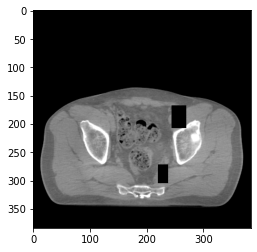

In [28]:
plt.imshow(x.squeeze(), 'gray'),

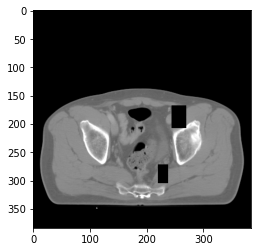

In [29]:
plt.imshow(y.squeeze(), 'gray')

In [30]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [31]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [32]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [33]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [34]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [35]:
edge_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [36]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [37]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_air, loss_bone, loss_edge_gen, loss_tf_gen, loss_edge_dis, loss_tf_dis = train_a2b_epoch(model, gen_optimizer, 
                                                                                             tf_discriminator, tf_dis_optimizer,
                                                                                             edge_discriminator, edge_dis_optimizer,
                                                                                             trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, score_tf_acc_train, score_edge_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            "loss edge gen": loss_edge_gen,
            "loss edge dis": loss_edge_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            "trainset edge acc score": score_edge_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
            "testset edge acc score": score_edge_acc_test
        })
        
        
        if score_air_test +  score_bone_test + score_cont_test >= max_score:
            max_score = score_air_test +  score_bone_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "edge_discriminator": edge_discriminator.state_dict(),
                "edge_dis_optimizer": edge_dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

84it [01:26,  1.03s/it]
84it [00:26,  3.14it/s]
12it [00:04,  2.86it/s]
84it [01:24,  1.01s/it]
84it [00:27,  3.10it/s]
12it [00:04,  2.84it/s]
84it [01:24,  1.01s/it]
84it [00:26,  3.13it/s]
12it [00:04,  2.84it/s]
84it [01:25,  1.01s/it]
84it [00:26,  3.12it/s]
12it [00:04,  2.86it/s]
84it [01:25,  1.01s/it]
84it [00:26,  3.12it/s]
12it [00:04,  2.87it/s]
84it [01:25,  1.01s/it]
84it [00:27,  3.10it/s]
12it [00:04,  2.83it/s]
84it [01:25,  1.01s/it]
84it [00:26,  3.12it/s]
12it [00:04,  2.86it/s]
84it [01:25,  1.01s/it]
84it [00:26,  3.12it/s]
12it [00:04,  2.85it/s]
84it [01:25,  1.01s/it]
84it [00:27,  3.09it/s]
12it [00:04,  2.85it/s]
84it [01:25,  1.01s/it]
84it [00:27,  3.09it/s]
12it [00:04,  2.80it/s]
84it [01:25,  1.01s/it]
84it [00:26,  3.12it/s]
12it [00:04,  2.86it/s]
84it [01:25,  1.02s/it]
84it [00:27,  3.11it/s]
12it [00:04,  2.86it/s]
84it [01:25,  1.02s/it]
84it [00:27,  3.10it/s]
12it [00:04,  2.85it/s]
84it [01:25,  1.02s/it]
84it [00:26,  3.11it/s]
12it [00:04,  2.

In [38]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [39]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [40]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8730844259262085
psnr score = 24.353740692138672
snr score = 14.41667652130127
mae error = 0.02123190276324749
air dice score = 0.9949630096017679
bone dice score = 0.9234732535244208
contour dice score = 0.46208953857421875


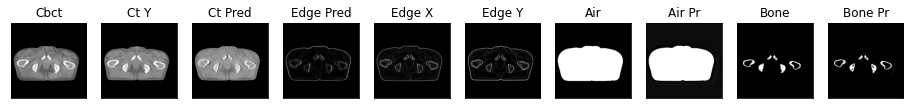

1it [00:00,  1.44it/s]

ssim score = 0.8729796409606934
psnr score = 24.19849395751953
snr score = 14.308967590332031
mae error = 0.021484768018126488
air dice score = 0.995281071196843
bone dice score = 0.9200603318262435
contour dice score = 0.5290245413780212


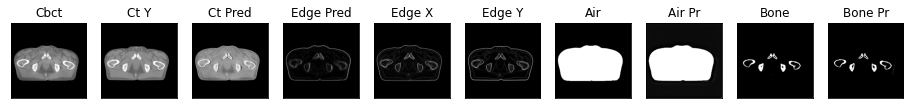

2it [00:01,  1.67it/s]

ssim score = 0.8700435161590576
psnr score = 24.162879943847656
snr score = 14.436248779296875
mae error = 0.021558158099651337
air dice score = 0.9954062109601752
bone dice score = 0.913175164059652
contour dice score = 0.4757339656352997


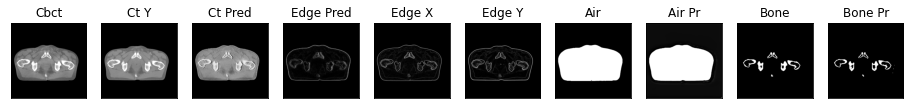

3it [00:01,  1.88it/s]

ssim score = 0.8668083548545837
psnr score = 24.14086151123047
snr score = 14.503483772277832
mae error = 0.02224833332002163
air dice score = 0.9957509735298509
bone dice score = 0.8992033252522894
contour dice score = 0.5186074376106262


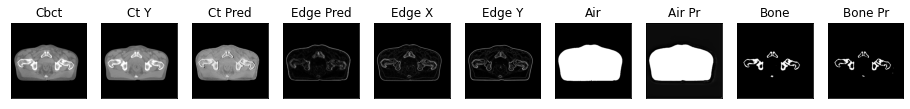

4it [00:01,  2.06it/s]

ssim score = 0.8614097237586975
psnr score = 24.19736099243164
snr score = 14.600284576416016
mae error = 0.02231486886739731
air dice score = 0.9964797785029205
bone dice score = 0.886584849768445
contour dice score = 0.5456730723381042


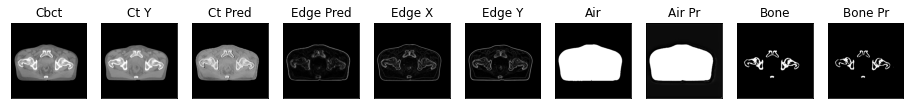

5it [00:02,  2.21it/s]

ssim score = 0.8592911958694458
psnr score = 24.1450138092041
snr score = 14.684475898742676
mae error = 0.022754820063710213
air dice score = 0.9968322691478935
bone dice score = 0.8391214567313767
contour dice score = 0.5545509457588196


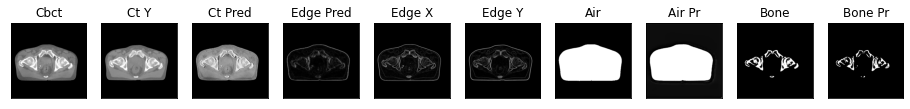

6it [00:02,  2.32it/s]

ssim score = 0.8583571314811707
psnr score = 23.893802642822266
snr score = 14.40920352935791
mae error = 0.023210207000374794
air dice score = 0.9964217175755673
bone dice score = 0.835379061373327
contour dice score = 0.4969770312309265


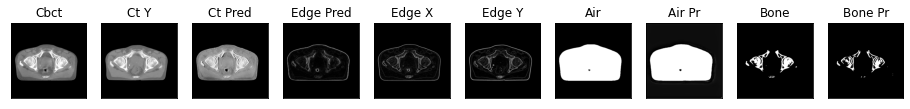

7it [00:02,  2.42it/s]

ssim score = 0.8633992075920105
psnr score = 24.251605987548828
snr score = 14.58147144317627
mae error = 0.02170499600470066
air dice score = 0.9965533526935131
bone dice score = 0.879923150817676
contour dice score = 0.4869459569454193


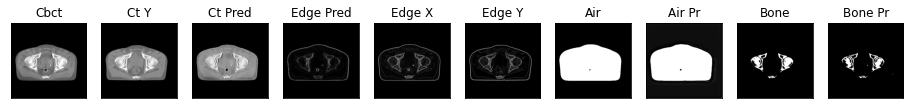

8it [00:03,  2.49it/s]

ssim score = 0.8656513690948486
psnr score = 24.535633087158203
snr score = 14.770942687988281
mae error = 0.020959919318556786
air dice score = 0.9965228641895478
bone dice score = 0.8995489954909845
contour dice score = 0.4884287416934967


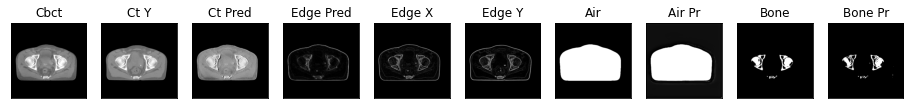

9it [00:03,  2.55it/s]

ssim score = 0.8686048984527588
psnr score = 24.466873168945312
snr score = 14.686898231506348
mae error = 0.020851733162999153
air dice score = 0.9960498452516737
bone dice score = 0.9072405385359139
contour dice score = 0.45177045464515686


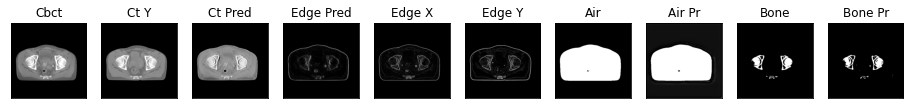

10it [00:04,  2.57it/s]

ssim score = 0.8744454979896545
psnr score = 24.703847885131836
snr score = 14.956145286560059
mae error = 0.01964249648153782
air dice score = 0.9955773050226299
bone dice score = 0.9211767347864229
contour dice score = 0.43887531757354736


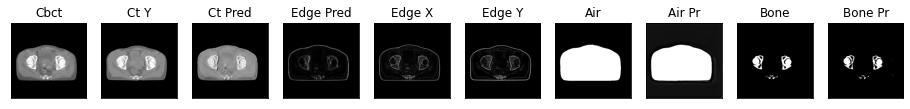

11it [00:04,  2.24it/s]

ssim score = 0.8747826218605042
psnr score = 24.076858520507812
snr score = 14.352865219116211
mae error = 0.02075297199189663
air dice score = 0.9950012936610659
bone dice score = 0.9228864122489825
contour dice score = 0.4362744987010956


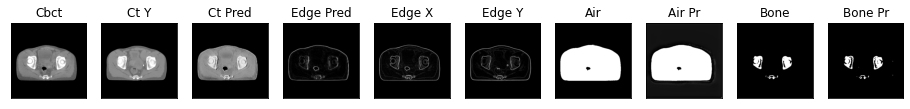

12it [00:05,  2.37it/s]

ssim score = 0.8777925372123718
psnr score = 23.482608795166016
snr score = 13.726696014404297
mae error = 0.021550914272665977
air dice score = 0.9946121253334784
bone dice score = 0.9365888348946712
contour dice score = 0.4742647111415863


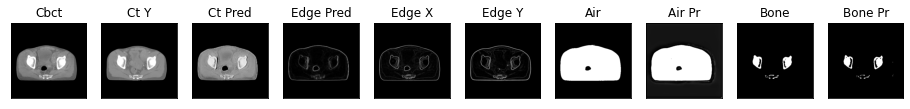

13it [00:05,  2.46it/s]

ssim score = 0.878416121006012
psnr score = 23.53472900390625
snr score = 13.636857032775879
mae error = 0.020922193303704262
air dice score = 0.9944625510236428
bone dice score = 0.8992616033768557
contour dice score = 0.4904261827468872


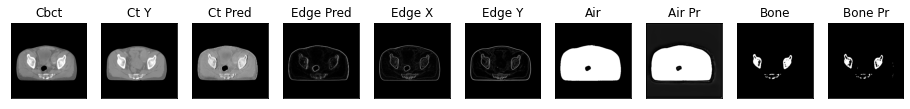

14it [00:05,  2.52it/s]

ssim score = 0.8752025961875916
psnr score = 23.344879150390625
snr score = 13.361345291137695
mae error = 0.02127016894519329
air dice score = 0.9948132670053832
bone dice score = 0.9003436426130537
contour dice score = 0.5040148496627808


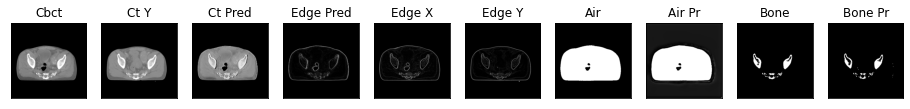

15it [00:06,  2.58it/s]

ssim score = 0.866870641708374
psnr score = 22.965238571166992
snr score = 13.005188941955566
mae error = 0.022340059280395508
air dice score = 0.9955823978829703
bone dice score = 0.9003994673781571
contour dice score = 0.4611528813838959


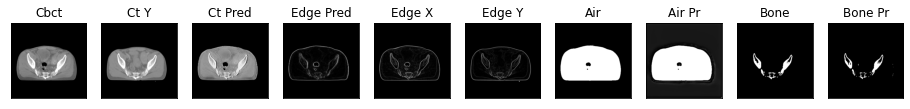

16it [00:06,  2.62it/s]

ssim score = 0.8621175289154053
psnr score = 22.3342342376709
snr score = 12.371644973754883
mae error = 0.0243623498827219
air dice score = 0.9950245534509794
bone dice score = 0.8914985958655668
contour dice score = 0.498113214969635


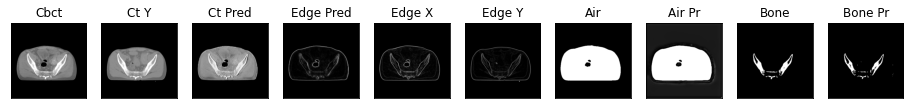

17it [00:06,  2.65it/s]

ssim score = 0.8573855757713318
psnr score = 21.84697914123535
snr score = 11.782626152038574
mae error = 0.025589419528841972
air dice score = 0.9938104785982109
bone dice score = 0.8661724541570273
contour dice score = 0.5164493918418884


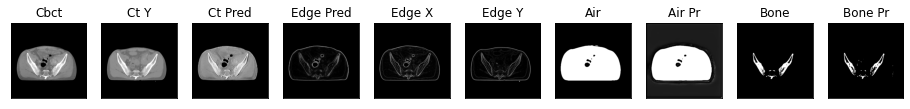

18it [00:07,  2.66it/s]

ssim score = 0.854551374912262
psnr score = 21.59457778930664
snr score = 11.479541778564453
mae error = 0.026478342711925507
air dice score = 0.9930538028509113
bone dice score = 0.8631471040509592
contour dice score = 0.5028717517852783


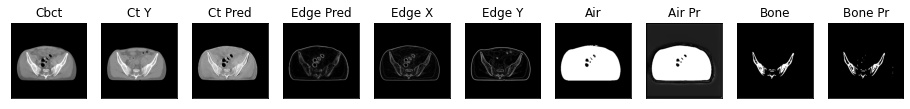

19it [00:07,  2.68it/s]

ssim score = 0.8575842976570129
psnr score = 21.590152740478516
snr score = 11.462806701660156
mae error = 0.026455475017428398
air dice score = 0.9938444196403972
bone dice score = 0.864320257927669
contour dice score = 0.42585551738739014


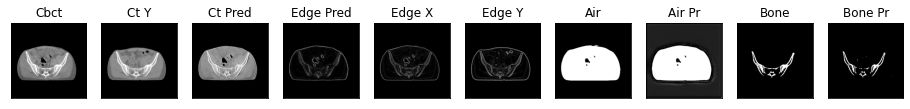

20it [00:07,  2.69it/s]

ssim score = 0.8533532619476318
psnr score = 21.44260597229004
snr score = 11.250414848327637
mae error = 0.026527700945734978
air dice score = 0.9938421721960756
bone dice score = 0.8493030080726441
contour dice score = 0.4435897469520569


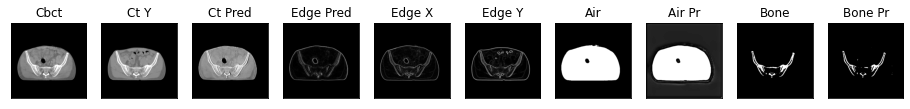

21it [00:08,  2.31it/s]

ssim score = 0.8482000231742859
psnr score = 21.334861755371094
snr score = 11.08324146270752
mae error = 0.026873571798205376
air dice score = 0.9917292219175712
bone dice score = 0.8626780626800188
contour dice score = 0.42295292019844055


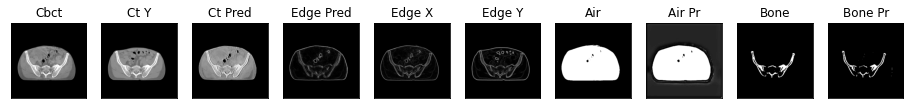

22it [00:08,  2.40it/s]

ssim score = 0.8548523783683777
psnr score = 21.529417037963867
snr score = 11.244367599487305
mae error = 0.0261190477758646
air dice score = 0.9930801343134664
bone dice score = 0.8579168359764605
contour dice score = 0.48051947355270386


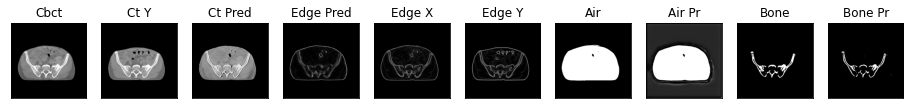

23it [00:09,  2.49it/s]

ssim score = 0.853815495967865
psnr score = 21.451839447021484
snr score = 11.118228912353516
mae error = 0.02651216648519039
air dice score = 0.9928609898357995
bone dice score = 0.8551633986947037
contour dice score = 0.41059601306915283


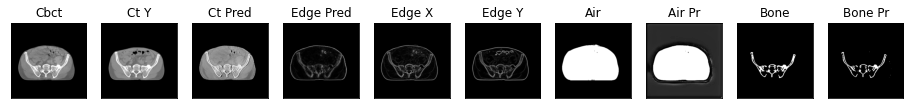

24it [00:09,  2.56it/s]

ssim score = 0.8504076600074768
psnr score = 21.357105255126953
snr score = 10.92648983001709
mae error = 0.027036799117922783
air dice score = 0.9906200964723768
bone dice score = 0.8407853071584448
contour dice score = 0.4115281403064728


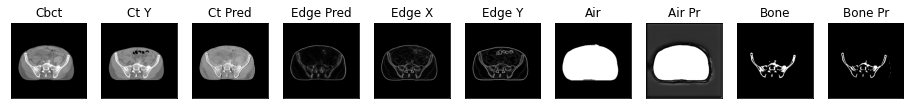

25it [00:10,  2.60it/s]

ssim score = 0.8516749739646912
psnr score = 21.37759017944336
snr score = 10.864242553710938
mae error = 0.027204202488064766
air dice score = 0.9756411607028179
bone dice score = 0.8413330017428334
contour dice score = 0.426630437374115


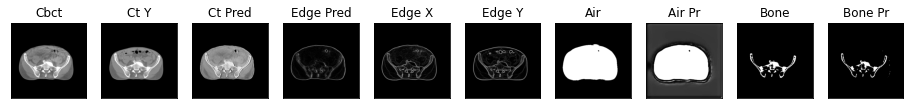

26it [00:10,  2.62it/s]

ssim score = 0.8506421446800232
psnr score = 21.459251403808594
snr score = 10.854717254638672
mae error = 0.02747439779341221
air dice score = 0.9719679565771483
bone dice score = 0.8464096563635126
contour dice score = 0.4077940285205841


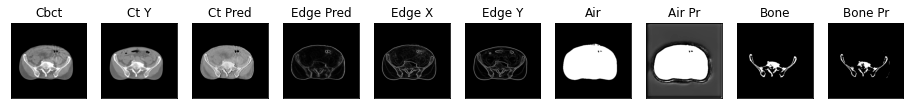

27it [00:10,  2.65it/s]

ssim score = 0.8514214158058167
psnr score = 21.514732360839844
snr score = 10.869091987609863
mae error = 0.02707088552415371
air dice score = 0.9695539637633546
bone dice score = 0.842142271184318
contour dice score = 0.3949224352836609


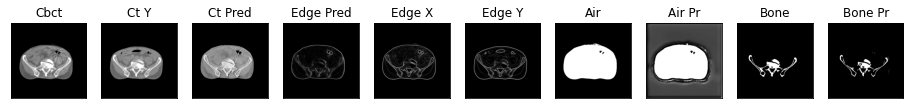

28it [00:11,  2.67it/s]

ssim score = 0.8175891041755676
psnr score = 21.89042854309082
snr score = 13.262585639953613
mae error = 0.03178701177239418
air dice score = 0.9953940475969107
bone dice score = 0.9280852323193819
contour dice score = 0.33191850781440735


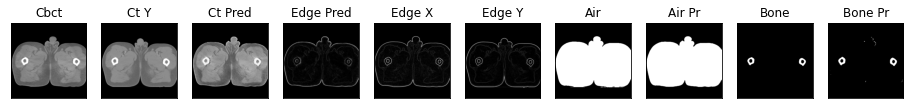

29it [00:11,  2.67it/s]

ssim score = 0.822563648223877
psnr score = 22.334415435791016
snr score = 13.745831489562988
mae error = 0.03047461062669754
air dice score = 0.9945288753799426
bone dice score = 0.9376572546844378
contour dice score = 0.31592249870300293


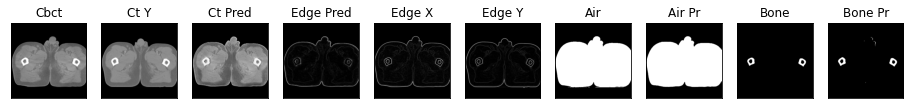

30it [00:12,  2.26it/s]

ssim score = 0.8292679786682129
psnr score = 22.987356185913086
snr score = 14.486218452453613
mae error = 0.02835661917924881
air dice score = 0.9939893211289129
bone dice score = 0.9480258755309385
contour dice score = 0.292553186416626


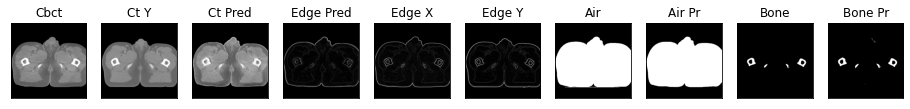

31it [00:12,  2.37it/s]

ssim score = 0.83519446849823
psnr score = 23.42245864868164
snr score = 15.083877563476562
mae error = 0.028224796056747437
air dice score = 0.9952695736551669
bone dice score = 0.9544387036174348
contour dice score = 0.27519556879997253


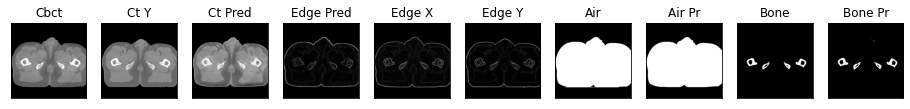

32it [00:12,  2.46it/s]

ssim score = 0.8385065197944641
psnr score = 23.632816314697266
snr score = 15.422380447387695
mae error = 0.029047366231679916
air dice score = 0.9948660956959793
bone dice score = 0.9493413011007831
contour dice score = 0.24048282206058502


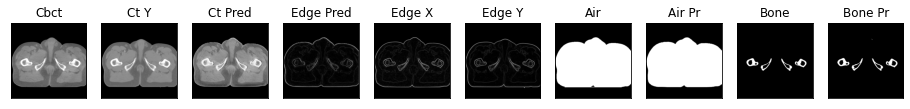

33it [00:13,  2.53it/s]

ssim score = 0.8376806974411011
psnr score = 23.763444900512695
snr score = 15.656244277954102
mae error = 0.030275041237473488
air dice score = 0.9951331612794582
bone dice score = 0.9419003668211821
contour dice score = 0.2632558047771454


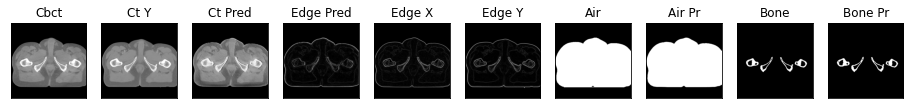

34it [00:13,  2.58it/s]

ssim score = 0.8387899398803711
psnr score = 24.1622371673584
snr score = 16.122142791748047
mae error = 0.030560404062271118
air dice score = 0.9946039930451498
bone dice score = 0.9355879408172701
contour dice score = 0.2242903709411621


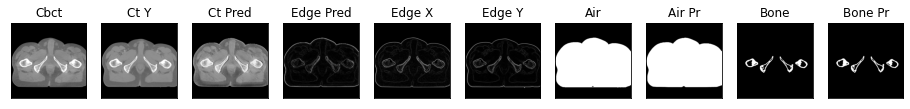

35it [00:13,  2.60it/s]

ssim score = 0.8396205306053162
psnr score = 24.338397979736328
snr score = 16.288410186767578
mae error = 0.030096329748630524
air dice score = 0.9948180334825595
bone dice score = 0.9455356194930934
contour dice score = 0.23283858597278595


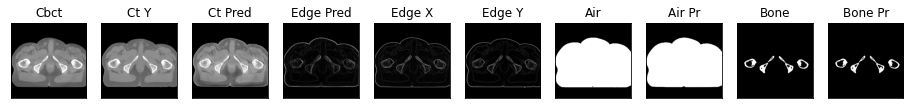

36it [00:14,  2.63it/s]

ssim score = 0.8429741859436035
psnr score = 24.498981475830078
snr score = 16.435331344604492
mae error = 0.029713809490203857
air dice score = 0.9948649438483728
bone dice score = 0.9478782773512912
contour dice score = 0.23229986429214478


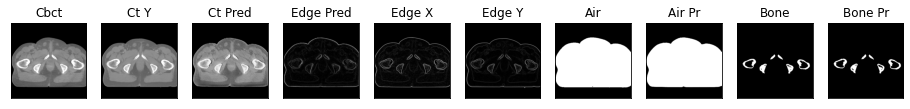

37it [00:14,  2.65it/s]

ssim score = 0.8437802791595459
psnr score = 24.63881492614746
snr score = 16.587162017822266
mae error = 0.0298034455627203
air dice score = 0.9949425451686146
bone dice score = 0.943178027355241
contour dice score = 0.22604651749134064


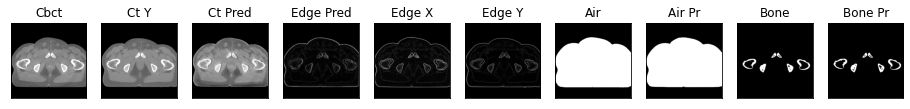

38it [00:15,  2.66it/s]

ssim score = 0.8463922739028931
psnr score = 24.533775329589844
snr score = 16.521209716796875
mae error = 0.03070630319416523
air dice score = 0.9947597837219858
bone dice score = 0.9367435487561458
contour dice score = 0.22553588449954987


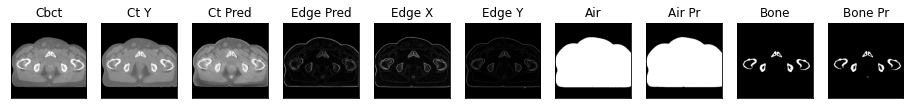

39it [00:15,  2.64it/s]

ssim score = 0.8427637815475464
psnr score = 24.20905876159668
snr score = 16.337783813476562
mae error = 0.033291045576334
air dice score = 0.9948476635792388
bone dice score = 0.9361407671022525
contour dice score = 0.2132834494113922


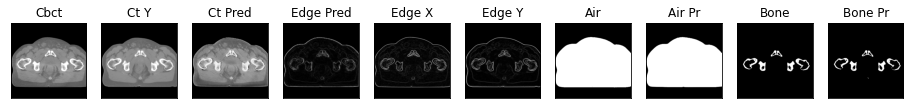

40it [00:16,  2.28it/s]

ssim score = 0.8441703915596008
psnr score = 23.945398330688477
snr score = 16.168806076049805
mae error = 0.03576897084712982
air dice score = 0.9947872556153335
bone dice score = 0.9181863811283404
contour dice score = 0.21180881559848785


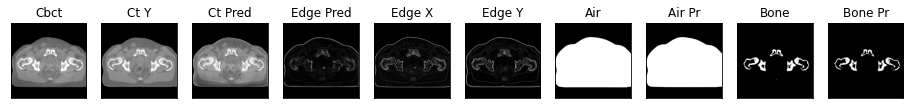

41it [00:16,  2.39it/s]

ssim score = 0.8350436091423035
psnr score = 23.329200744628906
snr score = 15.518566131591797
mae error = 0.036900296807289124
air dice score = 0.9944514607562087
bone dice score = 0.9039151712895276
contour dice score = 0.22932331264019012


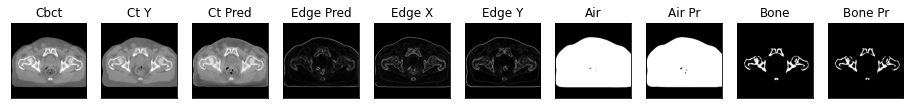

42it [00:16,  2.47it/s]

ssim score = 0.8335256576538086
psnr score = 22.57416534423828
snr score = 14.835715293884277
mae error = 0.03934865444898605
air dice score = 0.9938797392865355
bone dice score = 0.8484625027664002
contour dice score = 0.2205466479063034


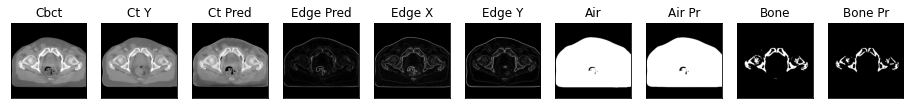

43it [00:17,  2.53it/s]

ssim score = 0.834252119064331
psnr score = 22.851642608642578
snr score = 14.977100372314453
mae error = 0.03697993978857994
air dice score = 0.994373636468025
bone dice score = 0.8802411619632754
contour dice score = 0.24622641503810883


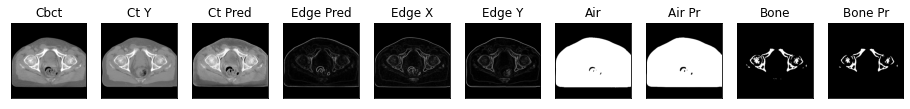

44it [00:17,  2.57it/s]

ssim score = 0.8389895558357239
psnr score = 23.30165672302246
snr score = 15.248550415039062
mae error = 0.03426344692707062
air dice score = 0.9947109821336645
bone dice score = 0.9021326321949349
contour dice score = 0.2709616422653198


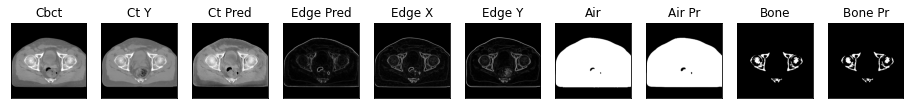

45it [00:17,  2.60it/s]

ssim score = 0.838578999042511
psnr score = 23.67790985107422
snr score = 15.53421401977539
mae error = 0.03228791430592537
air dice score = 0.995001819725831
bone dice score = 0.9061593034515085
contour dice score = 0.2712993919849396


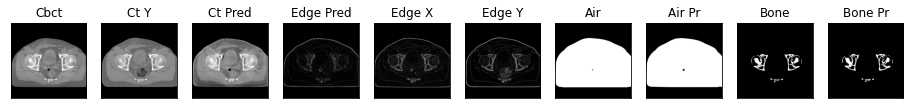

46it [00:18,  2.63it/s]

ssim score = 0.8433897495269775
psnr score = 24.019384384155273
snr score = 15.891379356384277
mae error = 0.030520806089043617
air dice score = 0.9955723377691187
bone dice score = 0.9090724372659853
contour dice score = 0.2843511402606964


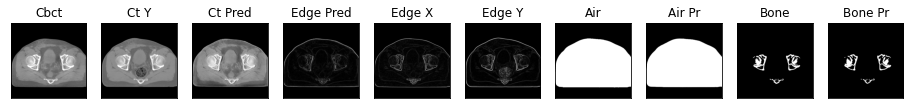

47it [00:18,  2.64it/s]

ssim score = 0.8295363783836365
psnr score = 23.587112426757812
snr score = 15.46914291381836
mae error = 0.03213632106781006
air dice score = 0.9954454742461186
bone dice score = 0.9192820984821051
contour dice score = 0.27533459663391113


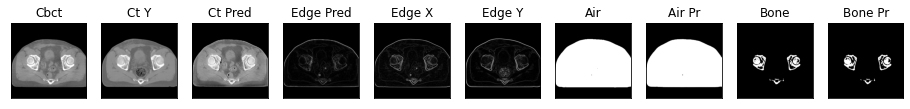

48it [00:19,  2.66it/s]

ssim score = 0.8366358876228333
psnr score = 23.843555450439453
snr score = 15.787176132202148
mae error = 0.03155142068862915
air dice score = 0.9953502085342436
bone dice score = 0.9243248225649892
contour dice score = 0.2966141998767853


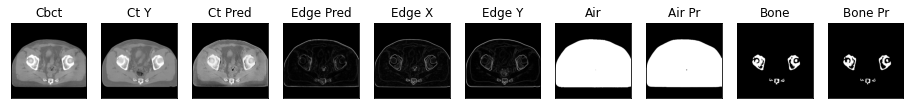

49it [00:19,  2.30it/s]

ssim score = 0.8366252779960632
psnr score = 23.897506713867188
snr score = 15.911211967468262
mae error = 0.0318918414413929
air dice score = 0.995055753612751
bone dice score = 0.9474624731956088
contour dice score = 0.2804005742073059


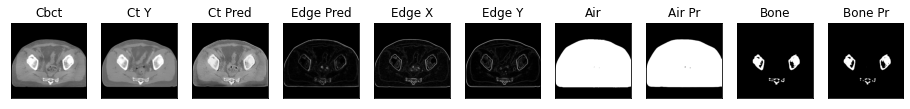

50it [00:19,  2.40it/s]

ssim score = 0.8450914025306702
psnr score = 24.00070571899414
snr score = 15.895303726196289
mae error = 0.030589977279305458
air dice score = 0.995074376908682
bone dice score = 0.9405020755095819
contour dice score = 0.2601238787174225


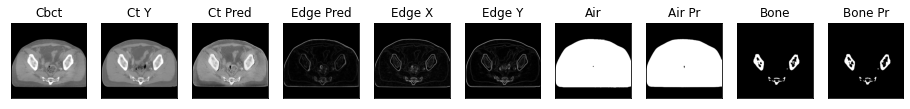

51it [00:20,  2.48it/s]

ssim score = 0.8396715521812439
psnr score = 23.384654998779297
snr score = 15.360878944396973
mae error = 0.032811809331178665
air dice score = 0.9945595312826985
bone dice score = 0.9311188811194833
contour dice score = 0.2614942491054535


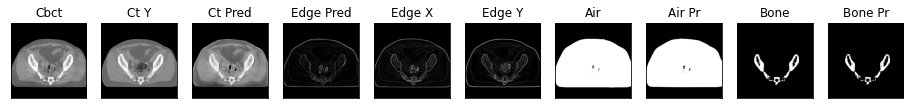

52it [00:20,  2.53it/s]

ssim score = 0.8432908654212952
psnr score = 23.391490936279297
snr score = 15.447859764099121
mae error = 0.033452510833740234
air dice score = 0.993676214824333
bone dice score = 0.9054928517689579
contour dice score = 0.20961537957191467


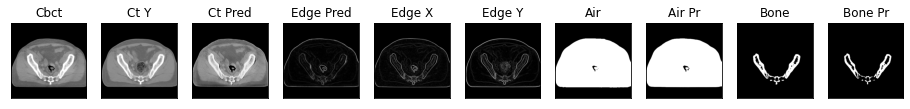

53it [00:21,  2.58it/s]

ssim score = 0.8221609592437744
psnr score = 23.087099075317383
snr score = 15.165027618408203
mae error = 0.034664642065763474
air dice score = 0.9941714726990837
bone dice score = 0.8845976304055655
contour dice score = 0.19864995777606964


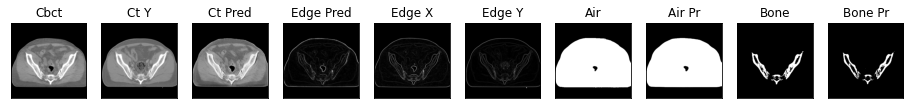

54it [00:21,  2.60it/s]

ssim score = 0.8205264806747437
psnr score = 23.496740341186523
snr score = 15.587206840515137
mae error = 0.03431861102581024
air dice score = 0.9941649850477777
bone dice score = 0.9026711697888957
contour dice score = 0.17140105366706848


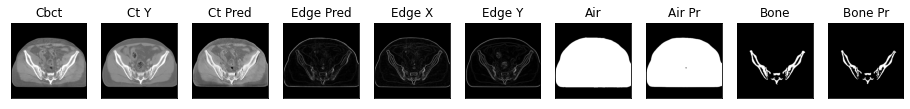

55it [00:21,  2.63it/s]

ssim score = 0.7884647250175476
psnr score = 20.110488891601562
snr score = 9.99069595336914
mae error = 0.03921487182378769
air dice score = 0.9956804997768892
bone dice score = 0.915463917527952
contour dice score = 0.5080243349075317


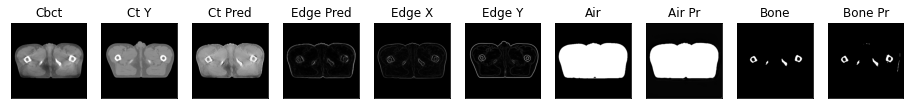

56it [00:22,  2.65it/s]

ssim score = 0.781490683555603
psnr score = 20.000171661376953
snr score = 10.09335994720459
mae error = 0.04000512883067131
air dice score = 0.9957117363472555
bone dice score = 0.9039203737577916
contour dice score = 0.4903581142425537


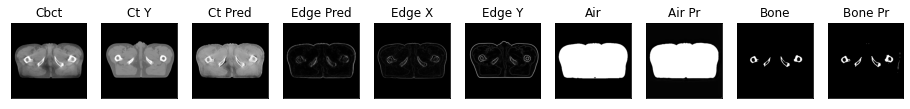

57it [00:22,  2.66it/s]

ssim score = 0.7778710126876831
psnr score = 20.05811882019043
snr score = 10.282445907592773
mae error = 0.04018319398164749
air dice score = 0.9958844829108929
bone dice score = 0.8813045127060807
contour dice score = 0.5098901391029358


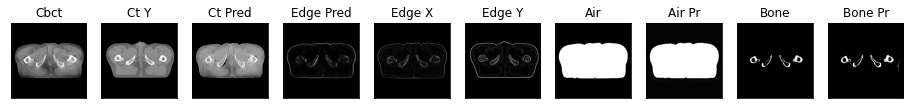

58it [00:22,  2.67it/s]

ssim score = 0.778134286403656
psnr score = 20.265180587768555
snr score = 10.55990982055664
mae error = 0.03956233337521553
air dice score = 0.9950919166153619
bone dice score = 0.8778722634362607
contour dice score = 0.47039473056793213


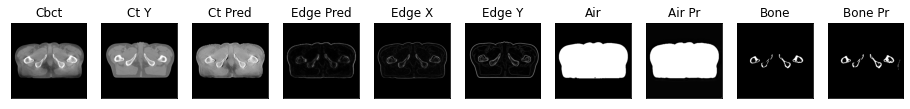

59it [00:23,  2.30it/s]

ssim score = 0.7795558571815491
psnr score = 20.3854923248291
snr score = 10.727788925170898
mae error = 0.0390598364174366
air dice score = 0.9945988601490622
bone dice score = 0.8687047181504028
contour dice score = 0.4765539765357971


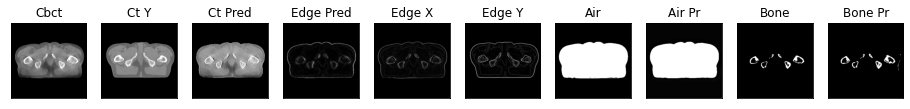

60it [00:23,  2.41it/s]

ssim score = 0.7749466300010681
psnr score = 20.406803131103516
snr score = 10.754714965820312
mae error = 0.039000265300273895
air dice score = 0.9940308160215398
bone dice score = 0.8843920464563718
contour dice score = 0.4715878963470459


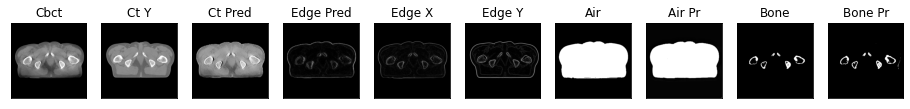

61it [00:24,  2.51it/s]

ssim score = 0.7747550010681152
psnr score = 20.397796630859375
snr score = 10.739203453063965
mae error = 0.03910769894719124
air dice score = 0.9938643890535176
bone dice score = 0.8859205776193877
contour dice score = 0.48988285660743713


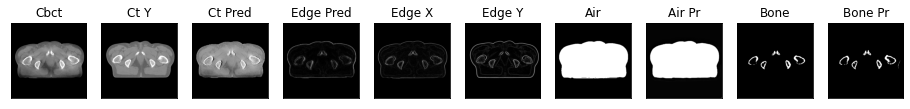

62it [00:24,  2.57it/s]

ssim score = 0.7761629223823547
psnr score = 20.32976531982422
snr score = 10.685285568237305
mae error = 0.03929108753800392
air dice score = 0.9945397883625489
bone dice score = 0.9007553135446907
contour dice score = 0.4391281306743622


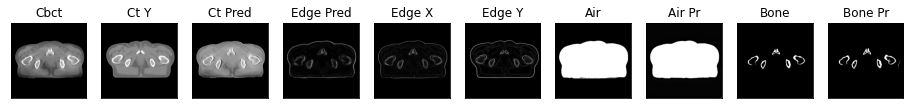

63it [00:25,  2.62it/s]

ssim score = 0.7753909826278687
psnr score = 20.2493896484375
snr score = 10.66291618347168
mae error = 0.039491165429353714
air dice score = 0.9949887289752081
bone dice score = 0.8985417313078103
contour dice score = 0.4954521059989929


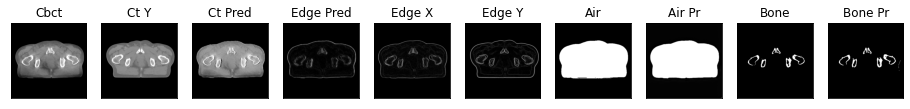

64it [00:25,  2.67it/s]

ssim score = 0.7691559195518494
psnr score = 20.262128829956055
snr score = 10.774215698242188
mae error = 0.03966224938631058
air dice score = 0.9946734919756548
bone dice score = 0.8714203894634677
contour dice score = 0.4613756537437439


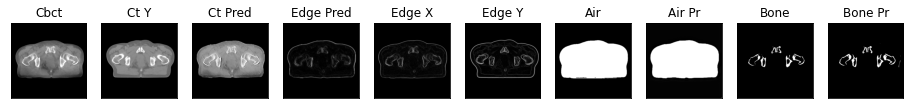

65it [00:25,  2.70it/s]

ssim score = 0.7581871747970581
psnr score = 20.172317504882812
snr score = 10.720230102539062
mae error = 0.04063153266906738
air dice score = 0.9943715469613308
bone dice score = 0.873068432672833
contour dice score = 0.46319183707237244


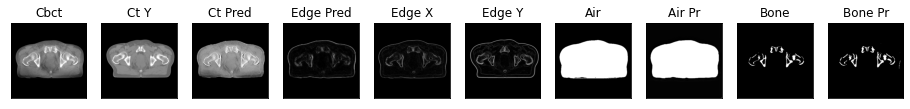

66it [00:26,  2.71it/s]

ssim score = 0.7496483325958252
psnr score = 20.123254776000977
snr score = 10.703876495361328
mae error = 0.0408686101436615
air dice score = 0.9950506147929751
bone dice score = 0.8609371084958539
contour dice score = 0.4606320261955261


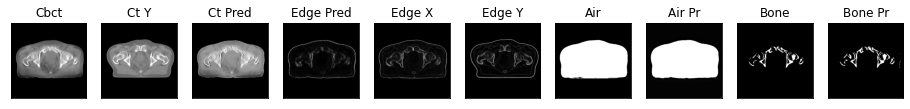

67it [00:26,  2.73it/s]

ssim score = 0.7523844838142395
psnr score = 20.27912139892578
snr score = 10.976560592651367
mae error = 0.039862096309661865
air dice score = 0.9954067958738761
bone dice score = 0.8692326081775132
contour dice score = 0.5287598967552185


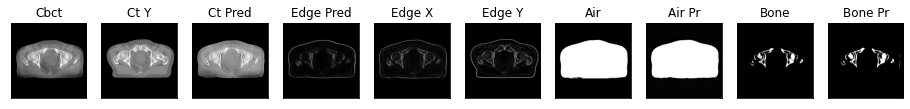

68it [00:26,  2.74it/s]

ssim score = 0.7572537660598755
psnr score = 20.36931610107422
snr score = 11.050766944885254
mae error = 0.039816875010728836
air dice score = 0.9956407870705437
bone dice score = 0.8623465751634902
contour dice score = 0.5174291729927063


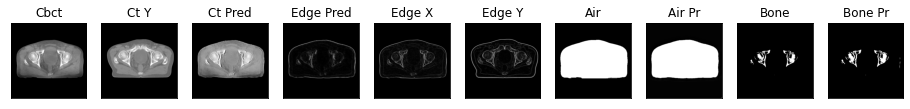

69it [00:27,  2.35it/s]

ssim score = 0.7724233269691467
psnr score = 20.765201568603516
snr score = 11.247489929199219
mae error = 0.0382462814450264
air dice score = 0.9956625759479546
bone dice score = 0.8730225395509866
contour dice score = 0.5427189469337463


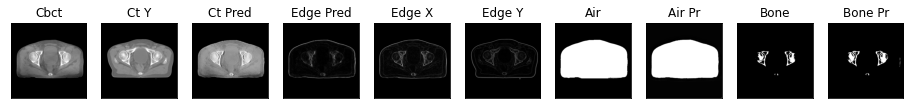

70it [00:27,  2.47it/s]

ssim score = 0.7865526080131531
psnr score = 21.147804260253906
snr score = 11.459702491760254
mae error = 0.036708153784275055
air dice score = 0.995641371721361
bone dice score = 0.907746100055033
contour dice score = 0.48034465312957764


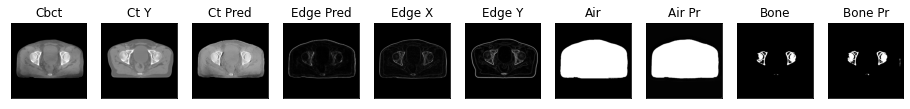

71it [00:28,  2.54it/s]

ssim score = 0.7884147763252258
psnr score = 21.391151428222656
snr score = 11.717216491699219
mae error = 0.036025576293468475
air dice score = 0.9957370159111415
bone dice score = 0.9250738979575238
contour dice score = 0.48772677779197693


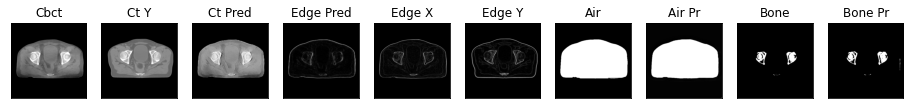

72it [00:28,  2.61it/s]

ssim score = 0.7937017679214478
psnr score = 21.642370223999023
snr score = 12.050264358520508
mae error = 0.03530450537800789
air dice score = 0.9957626030457932
bone dice score = 0.9314780782366568
contour dice score = 0.4514378607273102


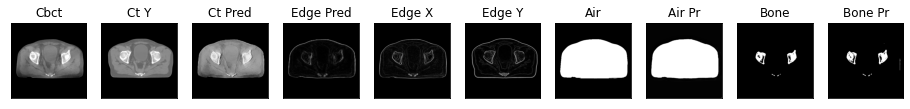

73it [00:28,  2.65it/s]

ssim score = 0.7950982451438904
psnr score = 21.47766876220703
snr score = 11.977733612060547
mae error = 0.03667885437607765
air dice score = 0.9964077578777645
bone dice score = 0.9162418062648763
contour dice score = 0.4722069203853607


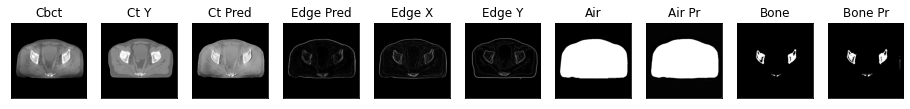

74it [00:29,  2.69it/s]

ssim score = 0.7890674471855164
psnr score = 21.67252540588379
snr score = 12.109163284301758
mae error = 0.03550252690911293
air dice score = 0.9963941898833245
bone dice score = 0.938827663313547
contour dice score = 0.4924892783164978


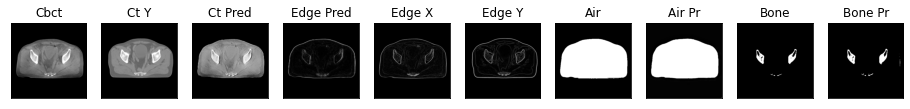

75it [00:29,  2.72it/s]

ssim score = 0.7945526838302612
psnr score = 21.752975463867188
snr score = 12.153221130371094
mae error = 0.03531869500875473
air dice score = 0.9957854666576067
bone dice score = 0.9264705882365515
contour dice score = 0.49440595507621765


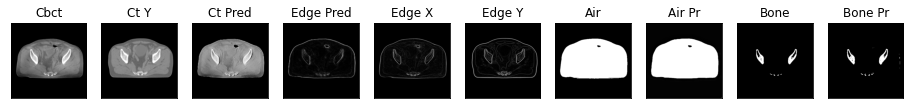

76it [00:29,  2.75it/s]

ssim score = 0.7912367582321167
psnr score = 21.48116683959961
snr score = 11.91915512084961
mae error = 0.03671039268374443
air dice score = 0.9959015696478106
bone dice score = 0.8898199875870605
contour dice score = 0.46709129214286804


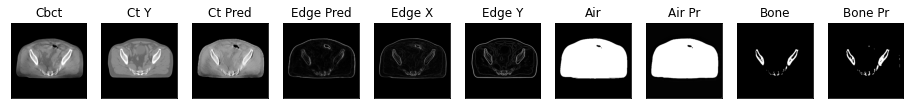

77it [00:30,  2.75it/s]

ssim score = 0.788332998752594
psnr score = 21.518768310546875
snr score = 12.087264060974121
mae error = 0.0365048423409462
air dice score = 0.9957876283922392
bone dice score = 0.9018619627621187
contour dice score = 0.4861111044883728


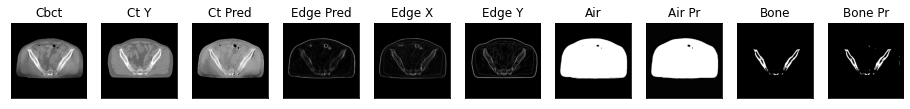

78it [00:30,  2.74it/s]

ssim score = 0.7937227487564087
psnr score = 21.445714950561523
snr score = 12.031960487365723
mae error = 0.03677143529057503
air dice score = 0.9960023234359552
bone dice score = 0.8827816580643367
contour dice score = 0.5053763389587402


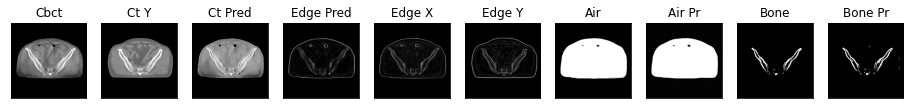

79it [00:31,  2.33it/s]

ssim score = 0.7936626672744751
psnr score = 21.778995513916016
snr score = 12.353971481323242
mae error = 0.03558465093374252
air dice score = 0.9959000223011374
bone dice score = 0.8800386971963876
contour dice score = 0.5064795017242432


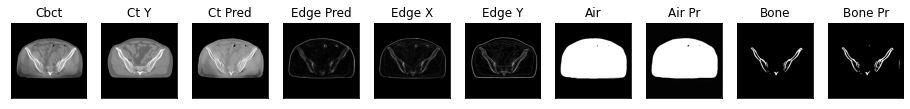

80it [00:31,  2.43it/s]

ssim score = 0.7962352633476257
psnr score = 21.905277252197266
snr score = 12.479511260986328
mae error = 0.03470858931541443
air dice score = 0.9959100028414752
bone dice score = 0.868058778037617
contour dice score = 0.46840959787368774


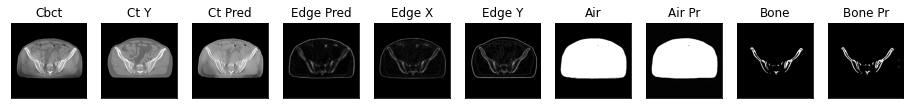

81it [00:31,  2.49it/s]

ssim score = 0.8524993062019348
psnr score = 22.817607879638672
snr score = 13.25174331665039
mae error = 0.028316494077444077
air dice score = 0.9951525474994666
bone dice score = 0.8686800135775813
contour dice score = 0.5389094948768616


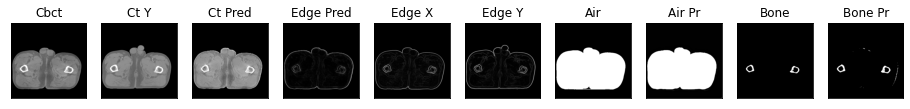

82it [00:32,  2.55it/s]

ssim score = 0.8539227247238159
psnr score = 23.167722702026367
snr score = 13.66624927520752
mae error = 0.02704230137169361
air dice score = 0.9954670231870106
bone dice score = 0.8675968992289117
contour dice score = 0.49842602014541626


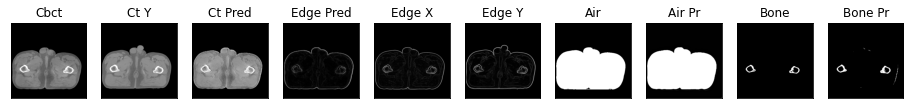

83it [00:32,  2.59it/s]

ssim score = 0.8542775511741638
psnr score = 24.494869232177734
snr score = 15.132608413696289
mae error = 0.023685144260525703
air dice score = 0.9962524546813051
bone dice score = 0.9030226700272246
contour dice score = 0.47922998666763306


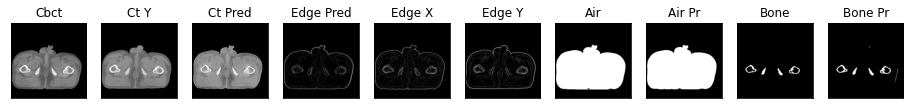

84it [00:33,  2.62it/s]

ssim score = 0.853983461856842
psnr score = 24.438505172729492
snr score = 15.197735786437988
mae error = 0.023207392543554306
air dice score = 0.9966677047648733
bone dice score = 0.8820977918004318
contour dice score = 0.49640288949012756


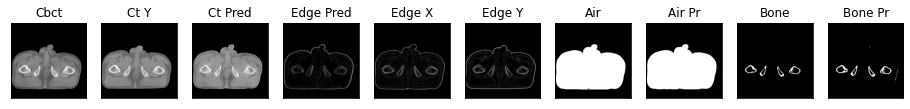

85it [00:33,  2.65it/s]

ssim score = 0.8502025604248047
psnr score = 24.263551712036133
snr score = 15.046957015991211
mae error = 0.023609817028045654
air dice score = 0.9967604856940898
bone dice score = 0.8539638386677139
contour dice score = 0.48858919739723206


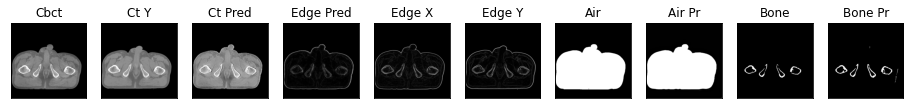

86it [00:33,  2.66it/s]

ssim score = 0.848300039768219
psnr score = 24.01409149169922
snr score = 14.793096542358398
mae error = 0.023863349109888077
air dice score = 0.9966796996214262
bone dice score = 0.8598028477572143
contour dice score = 0.4720626771450043


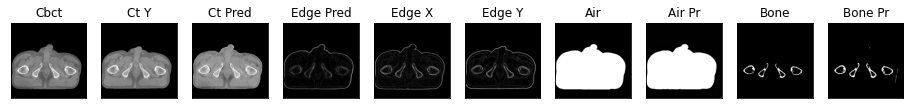

87it [00:34,  2.67it/s]

ssim score = 0.8495662212371826
psnr score = 23.613691329956055
snr score = 14.39895248413086
mae error = 0.024755485355854034
air dice score = 0.9966814502372634
bone dice score = 0.8707433174684961
contour dice score = 0.41009464859962463


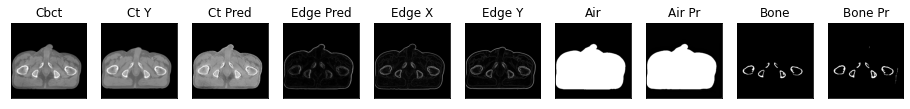

88it [00:34,  2.68it/s]

ssim score = 0.8461991548538208
psnr score = 23.346492767333984
snr score = 14.110198974609375
mae error = 0.025559384375810623
air dice score = 0.9970656730321401
bone dice score = 0.8845795263866385
contour dice score = 0.4164470136165619


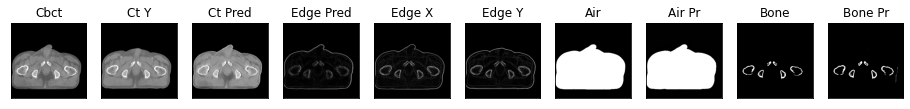

89it [00:35,  2.30it/s]

ssim score = 0.8465862274169922
psnr score = 23.358585357666016
snr score = 14.139200210571289
mae error = 0.02585435099899769
air dice score = 0.9968549542255738
bone dice score = 0.8958660387249979
contour dice score = 0.39703547954559326


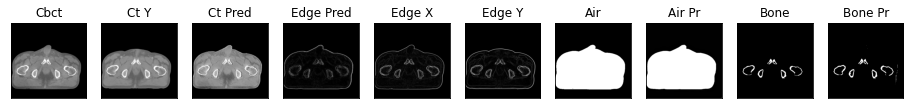

90it [00:35,  2.41it/s]

ssim score = 0.8487609624862671
psnr score = 23.792932510375977
snr score = 14.642142295837402
mae error = 0.024606021121144295
air dice score = 0.9972883634061928
bone dice score = 0.8987220447300523
contour dice score = 0.3776000142097473


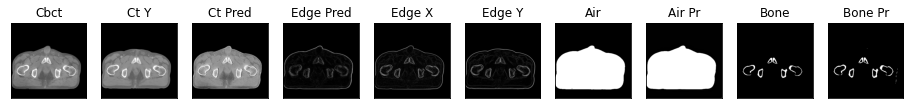

91it [00:35,  2.49it/s]

ssim score = 0.8481891751289368
psnr score = 24.25493049621582
snr score = 15.185497283935547
mae error = 0.023816578090190887
air dice score = 0.9974659312898665
bone dice score = 0.8987747958007763
contour dice score = 0.38754695653915405


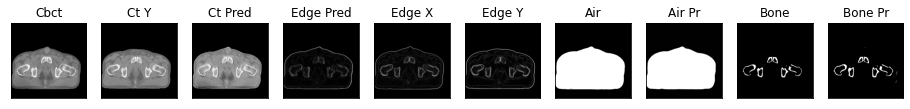

92it [00:36,  2.53it/s]

ssim score = 0.8493789434432983
psnr score = 24.639083862304688
snr score = 15.620354652404785
mae error = 0.023550469428300858
air dice score = 0.997668667202245
bone dice score = 0.88316668949619
contour dice score = 0.40515851974487305


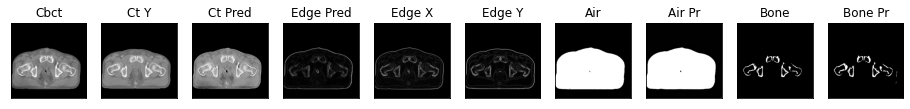

93it [00:36,  2.58it/s]

ssim score = 0.8491401076316833
psnr score = 24.956680297851562
snr score = 16.054216384887695
mae error = 0.023267189040780067
air dice score = 0.9974721541985959
bone dice score = 0.8751505419526944
contour dice score = 0.38858988881111145


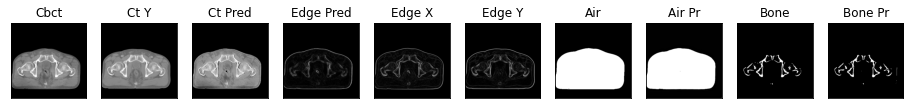

94it [00:36,  2.61it/s]

ssim score = 0.8517837524414062
psnr score = 24.69327163696289
snr score = 15.75257682800293
mae error = 0.02345576509833336
air dice score = 0.9978716645489216
bone dice score = 0.8531175896240324
contour dice score = 0.43272337317466736


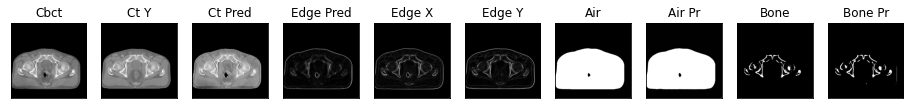

95it [00:37,  2.63it/s]

ssim score = 0.8480855822563171
psnr score = 24.010330200195312
snr score = 14.973962783813477
mae error = 0.025023579597473145
air dice score = 0.9973356376467221
bone dice score = 0.8665900676641569
contour dice score = 0.42093902826309204


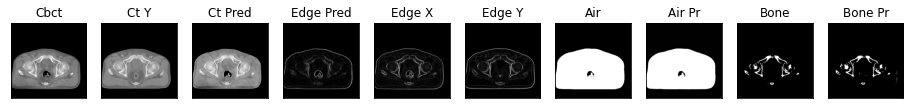

96it [00:37,  2.65it/s]

ssim score = 0.8509036302566528
psnr score = 23.66131019592285
snr score = 14.465184211730957
mae error = 0.025846367701888084
air dice score = 0.9972208124894293
bone dice score = 0.8518128479035383
contour dice score = 0.44480520486831665


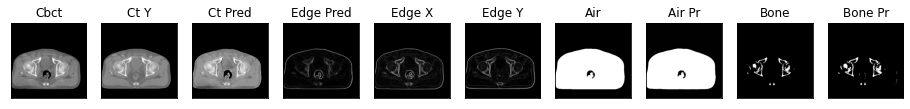

97it [00:38,  2.66it/s]

ssim score = 0.8522660136222839
psnr score = 23.40234375
snr score = 14.089792251586914
mae error = 0.026604363694787025
air dice score = 0.9969707333756804
bone dice score = 0.848236009734668
contour dice score = 0.43237370252609253


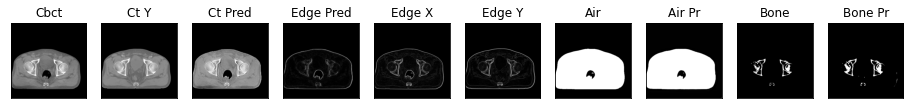

98it [00:38,  2.67it/s]

ssim score = 0.8483813405036926
psnr score = 23.263938903808594
snr score = 13.906292915344238
mae error = 0.02717995084822178
air dice score = 0.9968213396251173
bone dice score = 0.8715116279088443
contour dice score = 0.4564270079135895


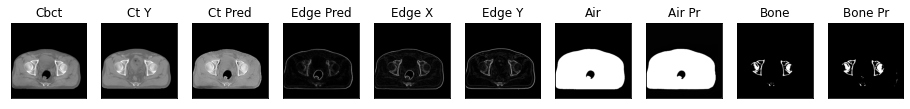

99it [00:39,  2.30it/s]

ssim score = 0.8417158126831055
psnr score = 22.772377014160156
snr score = 13.421403884887695
mae error = 0.02836916595697403
air dice score = 0.9967739022648382
bone dice score = 0.8942945599307932
contour dice score = 0.4462629556655884


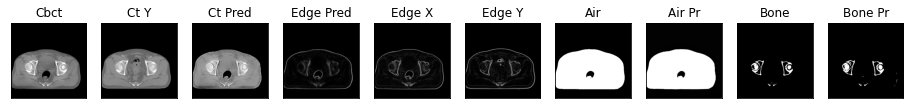

100it [00:39,  2.40it/s]

ssim score = 0.8472420573234558
psnr score = 22.533843994140625
snr score = 13.21297550201416
mae error = 0.02854381687939167
air dice score = 0.9966103368272122
bone dice score = 0.9219114219125596
contour dice score = 0.42255061864852905


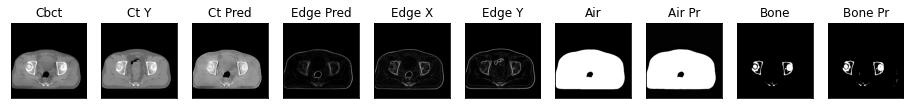

101it [00:39,  2.48it/s]

ssim score = 0.848042368888855
psnr score = 23.02314567565918
snr score = 13.659688949584961
mae error = 0.02693663164973259
air dice score = 0.9963188772575666
bone dice score = 0.9002831078971331
contour dice score = 0.4153424799442291


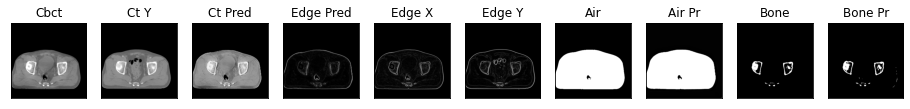

102it [00:40,  2.54it/s]

ssim score = 0.8504572510719299
psnr score = 23.191049575805664
snr score = 13.737390518188477
mae error = 0.026402093470096588
air dice score = 0.9960967478400111
bone dice score = 0.8953549517985039
contour dice score = 0.4247400164604187


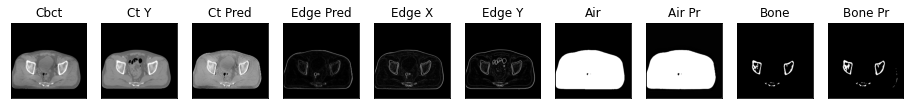

103it [00:40,  2.59it/s]

ssim score = 0.8514700531959534
psnr score = 22.90627670288086
snr score = 13.386892318725586
mae error = 0.027197295799851418
air dice score = 0.9960985044267001
bone dice score = 0.9106176525487849
contour dice score = 0.44456639885902405


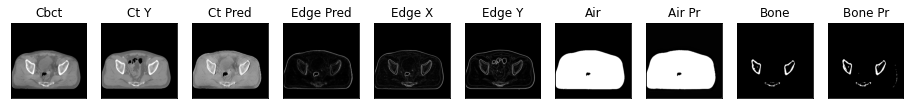

104it [00:40,  2.62it/s]

ssim score = 0.8470335602760315
psnr score = 22.906841278076172
snr score = 13.387154579162598
mae error = 0.02744208462536335
air dice score = 0.9957063514069927
bone dice score = 0.9139465875385107
contour dice score = 0.43784376978874207


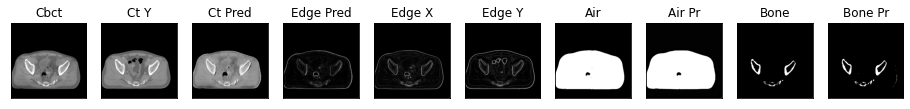

105it [00:41,  2.65it/s]

ssim score = 0.8405844569206238
psnr score = 22.982833862304688
snr score = 13.539312362670898
mae error = 0.027339093387126923
air dice score = 0.9959540955240626
bone dice score = 0.9164717214818154
contour dice score = 0.46935394406318665


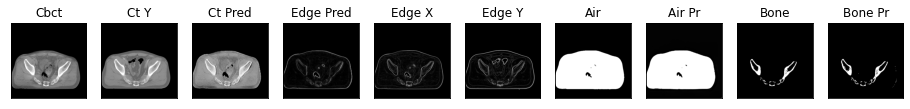

106it [00:41,  2.66it/s]

ssim score = 0.8411971926689148
psnr score = 22.899398803710938
snr score = 13.491462707519531
mae error = 0.027466297149658203
air dice score = 0.9956966478252739
bone dice score = 0.9097873464547644
contour dice score = 0.4254143536090851


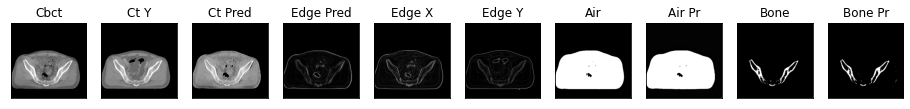

107it [00:42,  2.66it/s]

ssim score = 0.8435802459716797
psnr score = 23.27766227722168
snr score = 13.808025360107422
mae error = 0.02655198983848095
air dice score = 0.9957851544728046
bone dice score = 0.8934993084385409
contour dice score = 0.42216065526008606


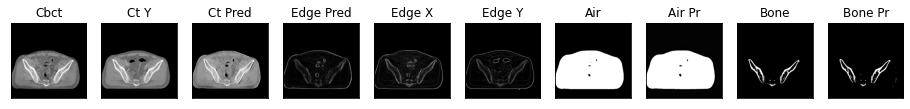

108it [00:42,  2.67it/s]

ssim score = 0.8390966653823853
psnr score = 23.16738510131836
snr score = 13.636489868164062
mae error = 0.02681264467537403
air dice score = 0.9952240872123246
bone dice score = 0.8779145546722966
contour dice score = 0.4031355082988739


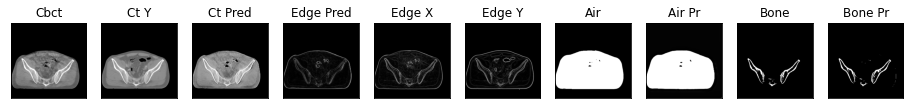

109it [00:42,  2.28it/s]

ssim score = 0.7474173307418823
psnr score = 21.22376251220703
snr score = 12.921070098876953
mae error = 0.039117563515901566
air dice score = 0.9956678100483095
bone dice score = 0.9306872037935223
contour dice score = 0.35620051622390747


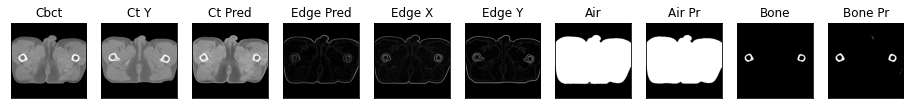

110it [00:43,  2.39it/s]

ssim score = 0.7367444634437561
psnr score = 20.923479080200195
snr score = 12.725077629089355
mae error = 0.04119117930531502
air dice score = 0.9954797592352204
bone dice score = 0.9281357730064138
contour dice score = 0.35283687710762024


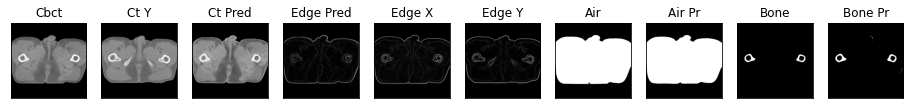

111it [00:43,  2.47it/s]

ssim score = 0.7330600023269653
psnr score = 20.810718536376953
snr score = 12.740272521972656
mae error = 0.042789824306964874
air dice score = 0.9956770554572054
bone dice score = 0.9037656903785823
contour dice score = 0.31706225872039795


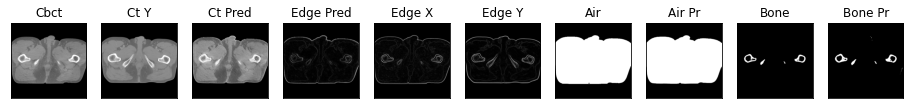

112it [00:44,  2.53it/s]

ssim score = 0.7295429110527039
psnr score = 20.642501831054688
snr score = 12.60434627532959
mae error = 0.04394298791885376
air dice score = 0.9954526518374247
bone dice score = 0.9216838760933808
contour dice score = 0.27685391902923584


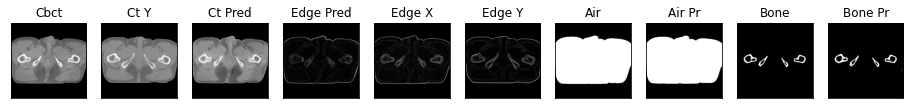

113it [00:44,  2.57it/s]

ssim score = 0.7191394567489624
psnr score = 20.54437828063965
snr score = 12.536459922790527
mae error = 0.045177873224020004
air dice score = 0.9952644918840794
bone dice score = 0.8975551222454244
contour dice score = 0.26775214076042175


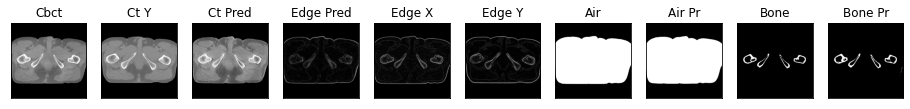

114it [00:44,  2.60it/s]

ssim score = 0.7163111567497253
psnr score = 20.56741714477539
snr score = 12.593915939331055
mae error = 0.04643316566944122
air dice score = 0.9954783866883731
bone dice score = 0.9118541033447408
contour dice score = 0.2870076894760132


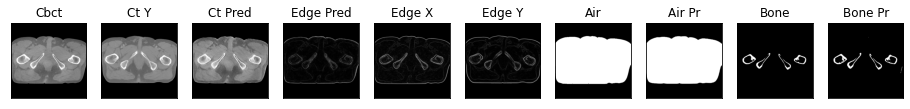

115it [00:45,  2.63it/s]

ssim score = 0.7101513147354126
psnr score = 20.382064819335938
snr score = 12.428874969482422
mae error = 0.048150788992643356
air dice score = 0.9952100263913622
bone dice score = 0.916356160864495
contour dice score = 0.2772009074687958


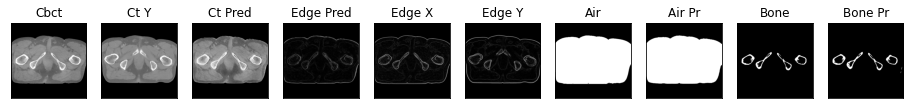

116it [00:45,  2.65it/s]

ssim score = 0.712925374507904
psnr score = 20.44180679321289
snr score = 12.52768611907959
mae error = 0.04736172780394554
air dice score = 0.9945433225360811
bone dice score = 0.9185338686709166
contour dice score = 0.2990570366382599


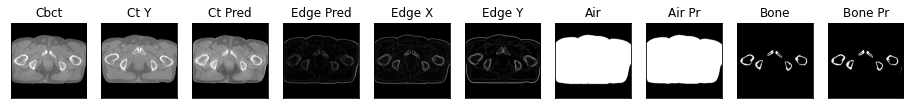

117it [00:45,  2.65it/s]

ssim score = 0.7113534212112427
psnr score = 20.466520309448242
snr score = 12.601081848144531
mae error = 0.048145074397325516
air dice score = 0.9939215902559702
bone dice score = 0.9266666666676069
contour dice score = 0.2766420245170593


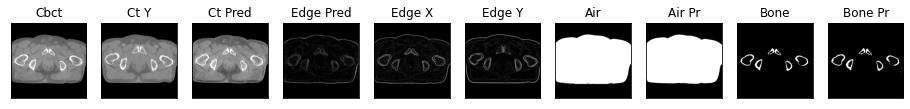

118it [00:46,  2.66it/s]

ssim score = 0.707291841506958
psnr score = 20.307825088500977
snr score = 12.464995384216309
mae error = 0.049998726695775986
air dice score = 0.9939358065957569
bone dice score = 0.929172857851298
contour dice score = 0.2716049253940582


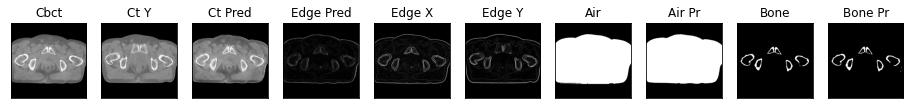

119it [00:46,  2.29it/s]

ssim score = 0.6971867680549622
psnr score = 20.14791488647461
snr score = 12.347865104675293
mae error = 0.05215669795870781
air dice score = 0.9945638644613394
bone dice score = 0.9262890760188454
contour dice score = 0.27280476689338684


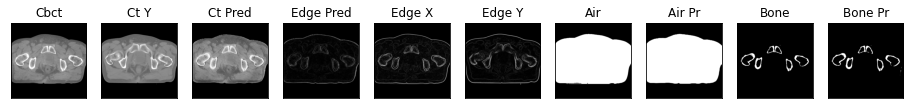

120it [00:47,  2.39it/s]

ssim score = 0.6994013786315918
psnr score = 20.135526657104492
snr score = 12.393816947937012
mae error = 0.05298852548003197
air dice score = 0.9943318248984148
bone dice score = 0.9184558434699265
contour dice score = 0.2836363613605499


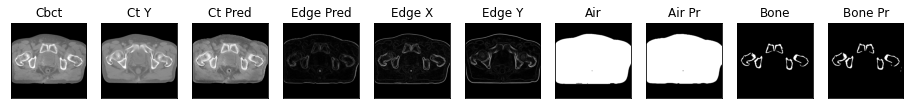

121it [00:47,  2.47it/s]

ssim score = 0.6951329112052917
psnr score = 20.01755142211914
snr score = 12.200470924377441
mae error = 0.054544225335121155
air dice score = 0.9947056380917259
bone dice score = 0.9010117040279606
contour dice score = 0.2704431116580963


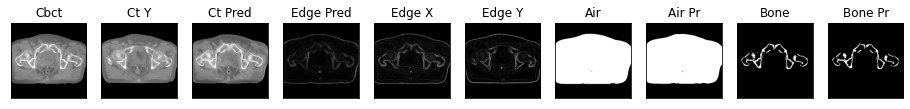

122it [00:48,  2.53it/s]

ssim score = 0.6959159970283508
psnr score = 20.05375099182129
snr score = 12.129449844360352
mae error = 0.0540970079600811
air dice score = 0.9946141071181468
bone dice score = 0.8876625936156123
contour dice score = 0.2728937864303589


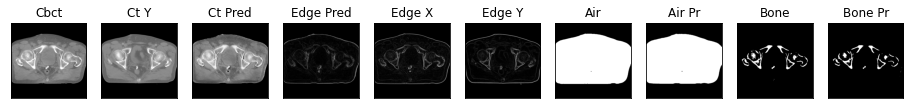

123it [00:48,  2.57it/s]

ssim score = 0.7083354592323303
psnr score = 20.476102828979492
snr score = 12.428711891174316
mae error = 0.050459109246730804
air dice score = 0.9949325299257801
bone dice score = 0.8642626795674361
contour dice score = 0.27757352590560913


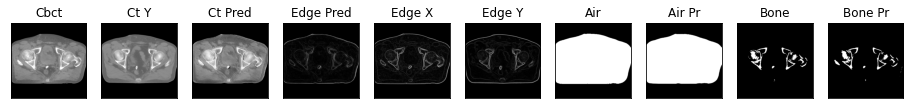

124it [00:48,  2.61it/s]

ssim score = 0.710540235042572
psnr score = 20.651418685913086
snr score = 12.491598129272461
mae error = 0.04774404317140579
air dice score = 0.9955701034028108
bone dice score = 0.8930716860242984
contour dice score = 0.2849239408969879


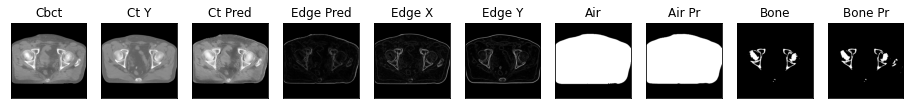

125it [00:49,  2.63it/s]

ssim score = 0.7062440514564514
psnr score = 20.904705047607422
snr score = 12.694239616394043
mae error = 0.04461095109581947
air dice score = 0.9956228585342689
bone dice score = 0.9227429699070278
contour dice score = 0.2750000059604645


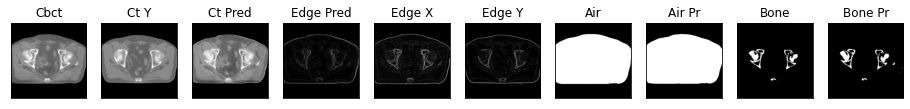

126it [00:49,  2.65it/s]

ssim score = 0.7084923386573792
psnr score = 20.825698852539062
snr score = 12.647388458251953
mae error = 0.045289695262908936
air dice score = 0.995671851912183
bone dice score = 0.9184226997713496
contour dice score = 0.267100989818573


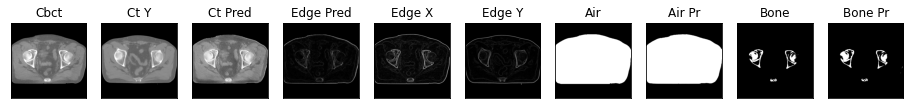

127it [00:49,  2.66it/s]

ssim score = 0.7056843042373657
psnr score = 20.599456787109375
snr score = 12.434621810913086
mae error = 0.04664325714111328
air dice score = 0.995812625197837
bone dice score = 0.9230426550849422
contour dice score = 0.2602996230125427


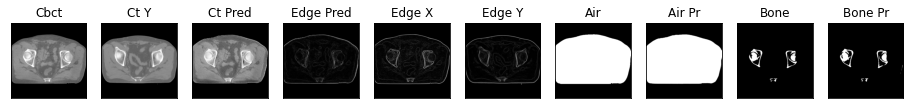

128it [00:50,  2.66it/s]

ssim score = 0.7037414908409119
psnr score = 20.365602493286133
snr score = 12.059277534484863
mae error = 0.04777407646179199
air dice score = 0.9954325568288586
bone dice score = 0.933923705722821
contour dice score = 0.23203381896018982


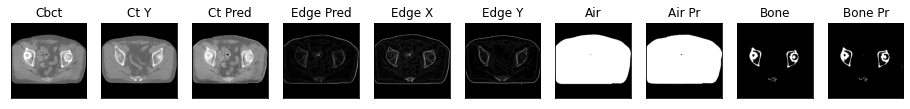

129it [00:50,  2.29it/s]

ssim score = 0.711113691329956
psnr score = 20.31562042236328
snr score = 11.949986457824707
mae error = 0.04740806296467781
air dice score = 0.9959767334851423
bone dice score = 0.9326166754072809
contour dice score = 0.23969683051109314


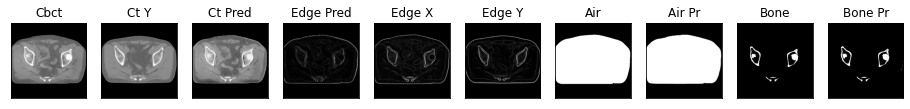

130it [00:51,  2.40it/s]

ssim score = 0.7067762017250061
psnr score = 20.417966842651367
snr score = 12.077980995178223
mae error = 0.04655970633029938
air dice score = 0.9962009636869048
bone dice score = 0.8871847307449355
contour dice score = 0.26325756311416626


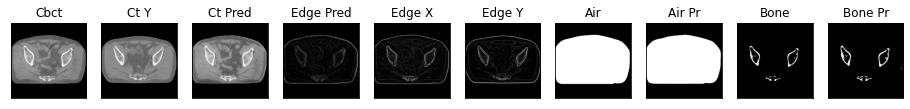

131it [00:51,  2.48it/s]

ssim score = 0.6999682784080505
psnr score = 20.167137145996094
snr score = 11.899965286254883
mae error = 0.04660247266292572
air dice score = 0.9957514256261161
bone dice score = 0.9107230292164074
contour dice score = 0.24420255422592163


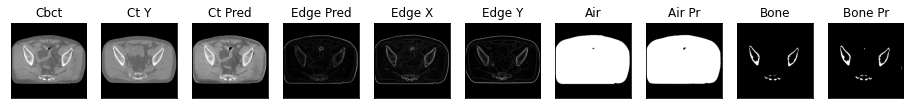

132it [00:51,  2.54it/s]

ssim score = 0.6958028674125671
psnr score = 19.879528045654297
snr score = 11.741584777832031
mae error = 0.048147235065698624
air dice score = 0.9959305984237836
bone dice score = 0.9177849760925839
contour dice score = 0.2491646707057953


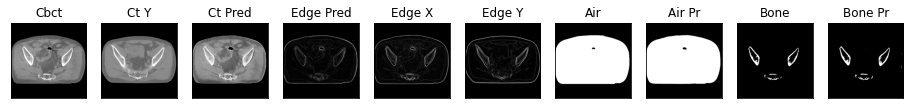

133it [00:52,  2.57it/s]

ssim score = 0.6933200359344482
psnr score = 19.745668411254883
snr score = 11.641684532165527
mae error = 0.0491841658949852
air dice score = 0.9956706302308219
bone dice score = 0.9221094754906087
contour dice score = 0.24207492172718048


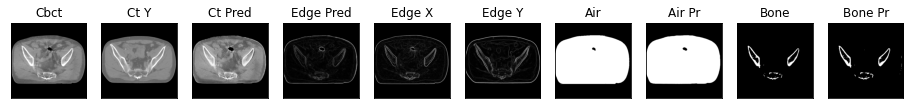

134it [00:52,  2.61it/s]

ssim score = 0.691565990447998
psnr score = 19.78748321533203
snr score = 11.653709411621094
mae error = 0.0501641221344471
air dice score = 0.9951663934277499
bone dice score = 0.9145740718501192
contour dice score = 0.18795180320739746


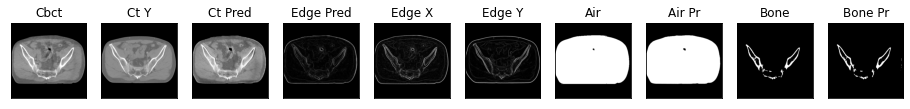

135it [00:53,  2.63it/s]

ssim score = 0.6857330799102783
psnr score = 19.969327926635742
snr score = 11.772176742553711
mae error = 0.04850782826542854
air dice score = 0.9957834578072793
bone dice score = 0.8976418100714131
contour dice score = 0.21169647574424744


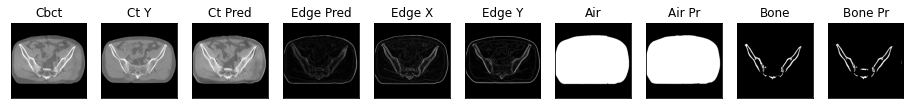

136it [00:53,  2.65it/s]

ssim score = 0.7970725297927856
psnr score = 22.27167320251465
snr score = 13.749064445495605
mae error = 0.03246636688709259
air dice score = 0.9960844335802571
bone dice score = 0.8935125657522675
contour dice score = 0.3117794394493103


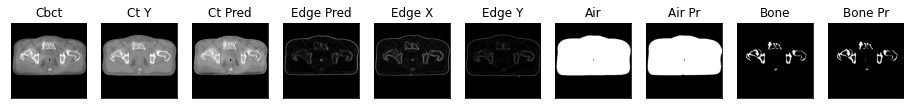

137it [00:53,  2.66it/s]

ssim score = 0.8019523620605469
psnr score = 22.380828857421875
snr score = 13.898231506347656
mae error = 0.03176620230078697
air dice score = 0.9962193942100199
bone dice score = 0.8782012744994805
contour dice score = 0.31499242782592773


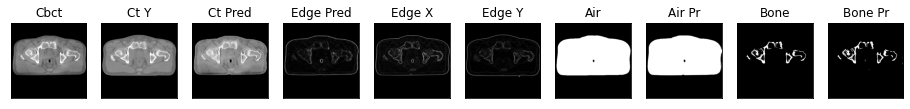

138it [00:54,  2.67it/s]

ssim score = 0.8035141229629517
psnr score = 22.55915641784668
snr score = 14.084346771240234
mae error = 0.03123285062611103
air dice score = 0.9963790251680129
bone dice score = 0.8871345750599835
contour dice score = 0.31594938039779663


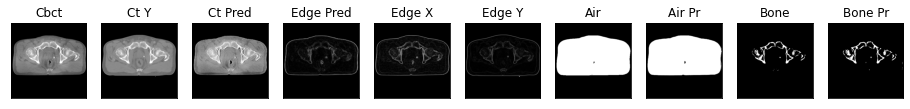

139it [00:54,  2.30it/s]

ssim score = 0.8077836632728577
psnr score = 22.600515365600586
snr score = 14.067286491394043
mae error = 0.030011726543307304
air dice score = 0.996367224290266
bone dice score = 0.8778322821784882
contour dice score = 0.31675127148628235


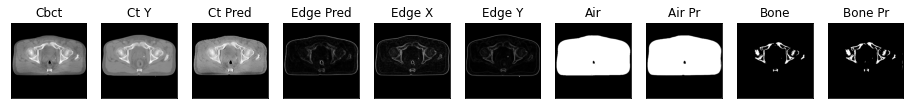

140it [00:55,  2.40it/s]

ssim score = 0.8169310092926025
psnr score = 22.605056762695312
snr score = 13.916202545166016
mae error = 0.029166867956519127
air dice score = 0.996320140299338
bone dice score = 0.8569123184527042
contour dice score = 0.3374108076095581


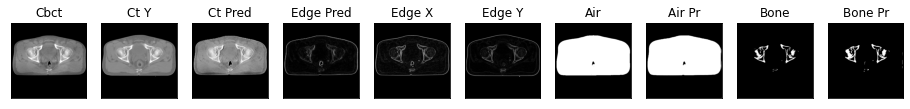

141it [00:55,  2.48it/s]

ssim score = 0.819861114025116
psnr score = 22.717159271240234
snr score = 14.007502555847168
mae error = 0.02845761924982071
air dice score = 0.9965432766731318
bone dice score = 0.8854568854583597
contour dice score = 0.3537832200527191


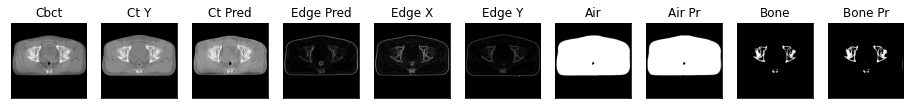

142it [00:55,  2.54it/s]

ssim score = 0.8130617737770081
psnr score = 22.52936363220215
snr score = 13.804075241088867
mae error = 0.029675189405679703
air dice score = 0.9966385287910788
bone dice score = 0.8958147818356975
contour dice score = 0.37185412645339966


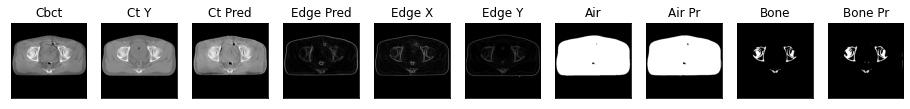

143it [00:56,  2.58it/s]

ssim score = 0.8047772645950317
psnr score = 22.040935516357422
snr score = 13.325013160705566
mae error = 0.031394243240356445
air dice score = 0.9965492190337839
bone dice score = 0.8929655870458886
contour dice score = 0.42349305748939514


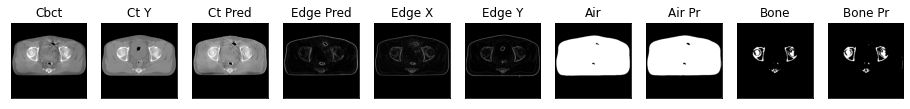

144it [00:56,  2.62it/s]

ssim score = 0.8000104427337646
psnr score = 21.978853225708008
snr score = 13.318710327148438
mae error = 0.032001323997974396
air dice score = 0.9968324214546636
bone dice score = 0.9117232543252822
contour dice score = 0.40516796708106995


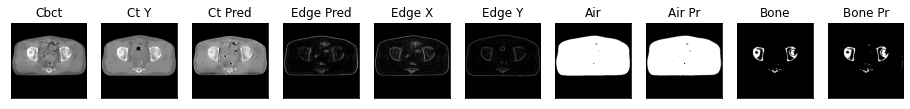

145it [00:57,  2.63it/s]

ssim score = 0.8016276359558105
psnr score = 21.609888076782227
snr score = 12.927816390991211
mae error = 0.03298798203468323
air dice score = 0.9964132048890101
bone dice score = 0.910061382440485
contour dice score = 0.41952231526374817


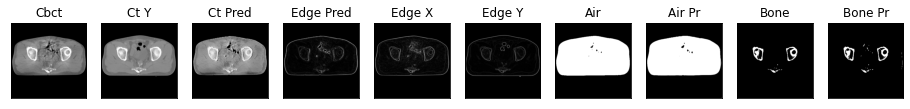

146it [00:57,  2.66it/s]

ssim score = 0.8016982078552246
psnr score = 21.130754470825195
snr score = 12.377911567687988
mae error = 0.03367361053824425
air dice score = 0.9964630298770872
bone dice score = 0.8790953899698595
contour dice score = 0.4290187954902649


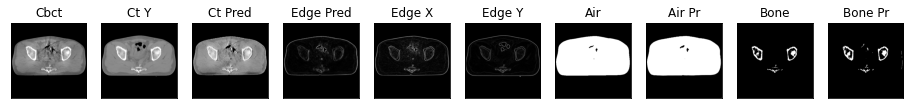

147it [00:57,  2.67it/s]

ssim score = 0.8052051067352295
psnr score = 21.332359313964844
snr score = 12.53562068939209
mae error = 0.03280940279364586
air dice score = 0.995969623041217
bone dice score = 0.8831168831186902
contour dice score = 0.44735464453697205


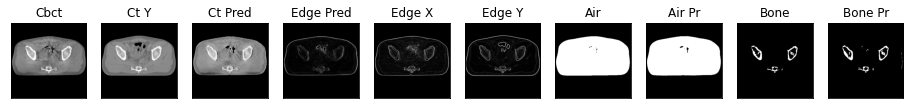

148it [00:58,  2.68it/s]

ssim score = 0.8031761646270752
psnr score = 21.555801391601562
snr score = 12.75796127319336
mae error = 0.03231717273592949
air dice score = 0.996194217666199
bone dice score = 0.9014379868199305
contour dice score = 0.4511041045188904


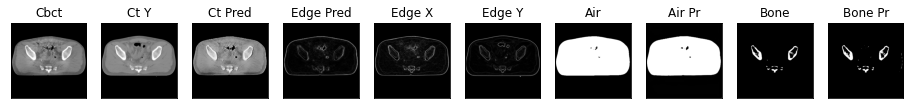

149it [00:58,  2.30it/s]

ssim score = 0.802261471748352
psnr score = 21.535717010498047
snr score = 12.751237869262695
mae error = 0.0330047607421875
air dice score = 0.9958698064357078
bone dice score = 0.9007206942211984
contour dice score = 0.4476040005683899


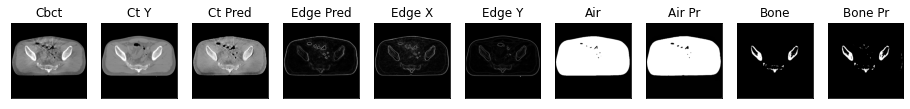

150it [00:59,  2.41it/s]

ssim score = 0.7992419004440308
psnr score = 21.506439208984375
snr score = 12.777164459228516
mae error = 0.03405163809657097
air dice score = 0.9960980443770062
bone dice score = 0.912555205048422
contour dice score = 0.4606444835662842


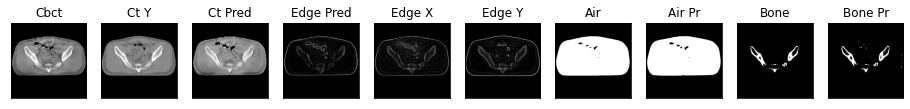

151it [00:59,  2.49it/s]

ssim score = 0.8028727173805237
psnr score = 21.144081115722656
snr score = 12.434173583984375
mae error = 0.03456183150410652
air dice score = 0.9954141610087329
bone dice score = 0.9075520833345371
contour dice score = 0.4613756537437439


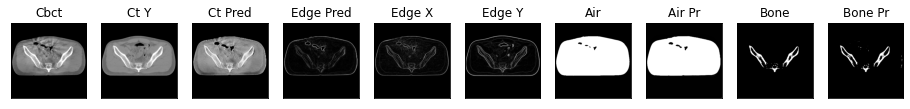

152it [00:59,  2.55it/s]

ssim score = 0.8046755790710449
psnr score = 21.233530044555664
snr score = 12.468886375427246
mae error = 0.033789608627557755
air dice score = 0.9948830069312037
bone dice score = 0.8934688762025698
contour dice score = 0.41251325607299805


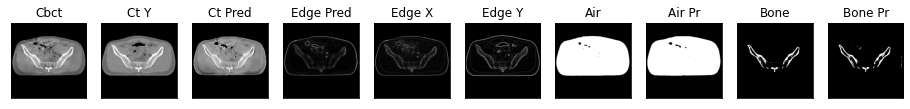

153it [01:00,  2.59it/s]

ssim score = 0.8081825375556946
psnr score = 21.509918212890625
snr score = 12.70892333984375
mae error = 0.032682523131370544
air dice score = 0.9954438383337502
bone dice score = 0.8835971424585572
contour dice score = 0.4176878035068512


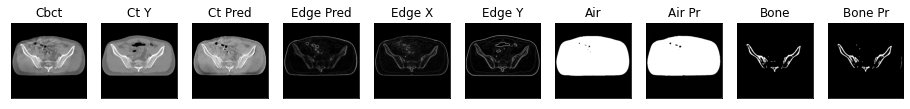

154it [01:00,  2.62it/s]

ssim score = 0.8110997676849365
psnr score = 21.743141174316406
snr score = 12.942217826843262
mae error = 0.03179438039660454
air dice score = 0.9961160683137875
bone dice score = 0.8811667723540753
contour dice score = 0.4355270266532898


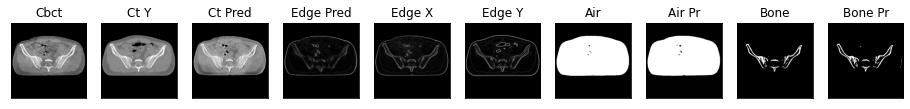

155it [01:00,  2.64it/s]

ssim score = 0.8089544177055359
psnr score = 21.869182586669922
snr score = 13.066837310791016
mae error = 0.031824979931116104
air dice score = 0.9960716115708926
bone dice score = 0.8891998473490752
contour dice score = 0.4068891406059265


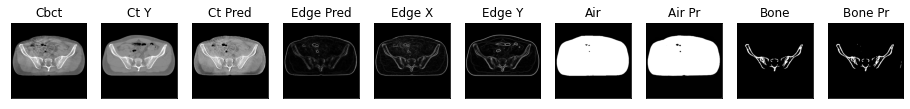

156it [01:01,  2.66it/s]

ssim score = 0.7997973561286926
psnr score = 21.3521671295166
snr score = 12.55486011505127
mae error = 0.03358563408255577
air dice score = 0.9952549028774493
bone dice score = 0.8703871552522285
contour dice score = 0.4142780005931854


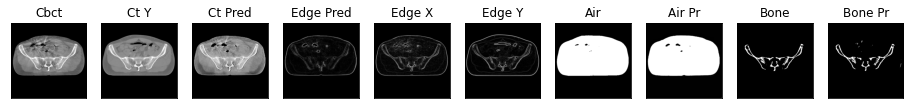

157it [01:01,  2.67it/s]

ssim score = 0.7934115529060364
psnr score = 20.950767517089844
snr score = 12.136187553405762
mae error = 0.035533513873815536
air dice score = 0.995062250080213
bone dice score = 0.8521309771328985
contour dice score = 0.4082743525505066


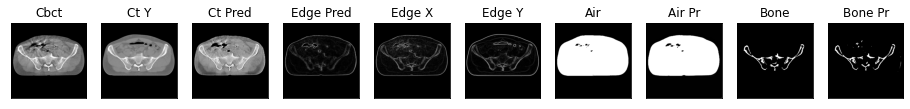

158it [01:02,  2.67it/s]

ssim score = 0.7868914008140564
psnr score = 20.628110885620117
snr score = 11.794909477233887
mae error = 0.03733097389340401
air dice score = 0.9951288497800164
bone dice score = 0.8521347189200935
contour dice score = 0.4462719261646271


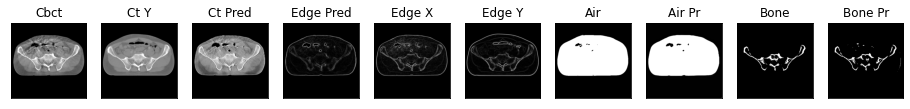

159it [01:02,  2.27it/s]

ssim score = 0.7784632444381714
psnr score = 20.392648696899414
snr score = 11.513508796691895
mae error = 0.038760315626859665
air dice score = 0.9950403318010179
bone dice score = 0.8604009122571071
contour dice score = 0.4421168565750122


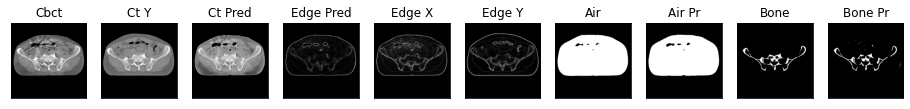

160it [01:03,  2.38it/s]

ssim score = 0.7762394547462463
psnr score = 20.404674530029297
snr score = 11.471735000610352
mae error = 0.03881719335913658
air dice score = 0.994870089773433
bone dice score = 0.8710433763203863
contour dice score = 0.4603438675403595


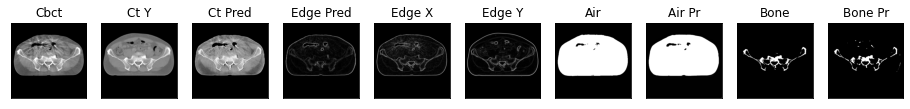

161it [01:03,  2.47it/s]

ssim score = 0.766680121421814
psnr score = 20.120346069335938
snr score = 11.21787166595459
mae error = 0.04074651002883911
air dice score = 0.9949526663434294
bone dice score = 0.8738915121516307
contour dice score = 0.45297718048095703


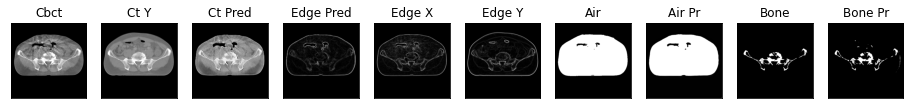

162it [01:03,  2.53it/s]

ssim score = 0.7579017877578735
psnr score = 19.894426345825195
snr score = 10.936725616455078
mae error = 0.04168795421719551
air dice score = 0.994662715482909
bone dice score = 0.8696379495773731
contour dice score = 0.4516128897666931


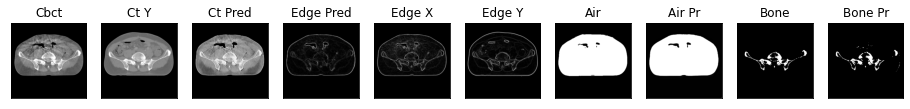

163it [01:04,  2.57it/s]

ssim score = 0.761282742023468
psnr score = 20.402334213256836
snr score = 11.297100067138672
mae error = 0.03980658948421478
air dice score = 0.9952802359882044
bone dice score = 0.8881213765895137
contour dice score = 0.3796761631965637


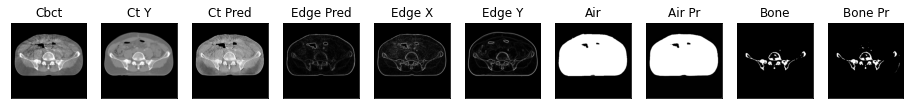

164it [01:04,  2.61it/s]

ssim score = 0.8212884068489075
psnr score = 22.91427993774414
snr score = 13.295193672180176
mae error = 0.035308778285980225
air dice score = 0.9958212745850837
bone dice score = 0.8885017421630537
contour dice score = 0.4166666567325592


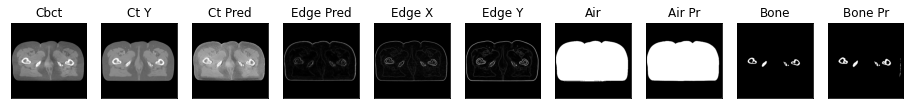

165it [01:04,  2.64it/s]

ssim score = 0.8212807178497314
psnr score = 23.185043334960938
snr score = 13.686969757080078
mae error = 0.03384611755609512
air dice score = 0.9955989789631227
bone dice score = 0.8996818663860089
contour dice score = 0.386745810508728


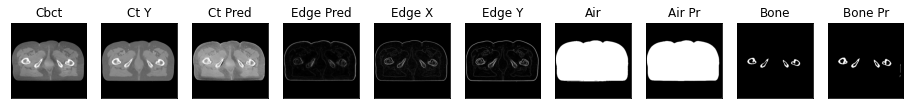

166it [01:05,  2.65it/s]

ssim score = 0.8180407881736755
psnr score = 23.270797729492188
snr score = 13.855639457702637
mae error = 0.03286480903625488
air dice score = 0.9956476411965008
bone dice score = 0.8839385997775376
contour dice score = 0.3583984375


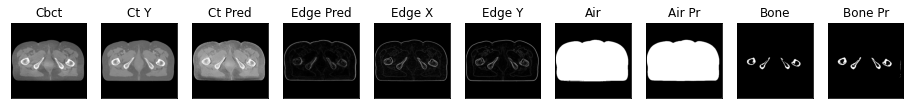

167it [01:05,  2.67it/s]

ssim score = 0.8146811723709106
psnr score = 23.277698516845703
snr score = 13.925983428955078
mae error = 0.032368529587984085
air dice score = 0.9955229837100493
bone dice score = 0.8942866917568545
contour dice score = 0.37756097316741943


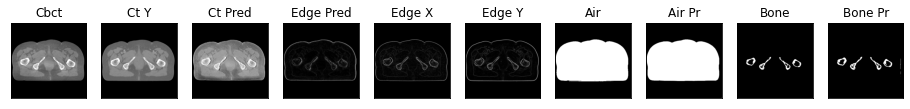

168it [01:05,  2.67it/s]

ssim score = 0.8166782259941101
psnr score = 23.28169059753418
snr score = 13.958439826965332
mae error = 0.03230874240398407
air dice score = 0.9953565073992136
bone dice score = 0.9008649367947295
contour dice score = 0.3571077287197113


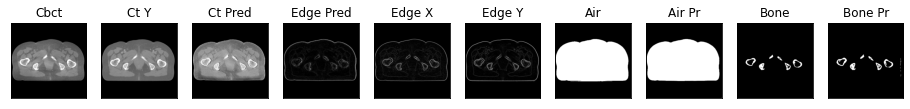

169it [01:06,  2.30it/s]

ssim score = 0.8183032870292664
psnr score = 23.15899658203125
snr score = 13.858698844909668
mae error = 0.03284585475921631
air dice score = 0.9953834612499312
bone dice score = 0.9057384111682623
contour dice score = 0.35797664523124695


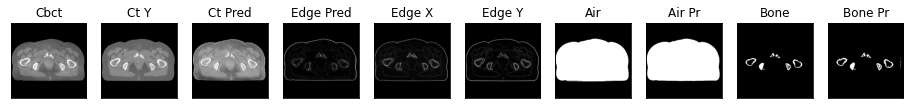

170it [01:06,  2.41it/s]

ssim score = 0.8147003054618835
psnr score = 23.131086349487305
snr score = 13.862114906311035
mae error = 0.03270517289638519
air dice score = 0.995198710058238
bone dice score = 0.9078207531111293
contour dice score = 0.3449275493621826


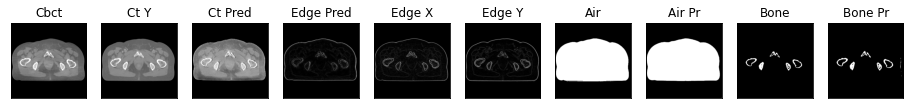

171it [01:07,  2.49it/s]

ssim score = 0.8126149773597717
psnr score = 22.95374870300293
snr score = 13.73314380645752
mae error = 0.03283088281750679
air dice score = 0.9953270356151811
bone dice score = 0.8996380388302132
contour dice score = 0.32267168164253235


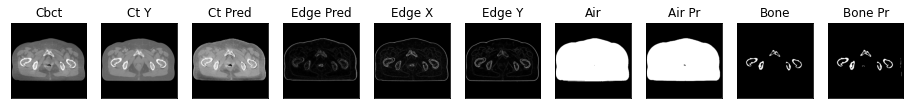

172it [01:07,  2.55it/s]

ssim score = 0.8150300979614258
psnr score = 22.825496673583984
snr score = 13.64763355255127
mae error = 0.032682571560144424
air dice score = 0.9952248079855053
bone dice score = 0.8915187376742297
contour dice score = 0.3392599821090698


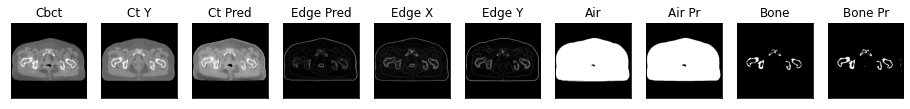

173it [01:08,  2.58it/s]

ssim score = 0.8132147192955017
psnr score = 22.871551513671875
snr score = 13.781390190124512
mae error = 0.03191961348056793
air dice score = 0.9951378100005789
bone dice score = 0.8889762747425747
contour dice score = 0.3457943797111511


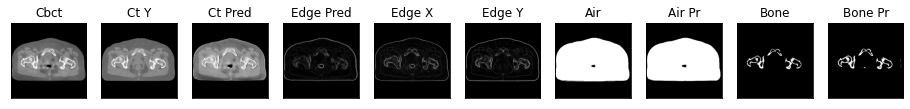

174it [01:08,  2.62it/s]

ssim score = 0.8131443858146667
psnr score = 23.617633819580078
snr score = 14.6407470703125
mae error = 0.029538163915276527
air dice score = 0.9947805167932793
bone dice score = 0.9063756461814315
contour dice score = 0.27411168813705444


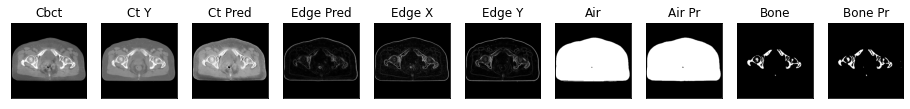

175it [01:08,  2.64it/s]

ssim score = 0.8173142075538635
psnr score = 23.018714904785156
snr score = 13.913276672363281
mae error = 0.031655143946409225
air dice score = 0.9945999440631694
bone dice score = 0.8577081114007349
contour dice score = 0.352886825799942


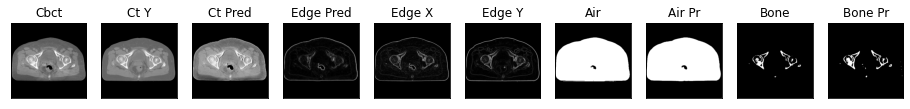

176it [01:09,  2.65it/s]

ssim score = 0.8199512362480164
psnr score = 22.951427459716797
snr score = 13.736563682556152
mae error = 0.03243742510676384
air dice score = 0.9946399140093195
bone dice score = 0.8364355130977362
contour dice score = 0.37348273396492004


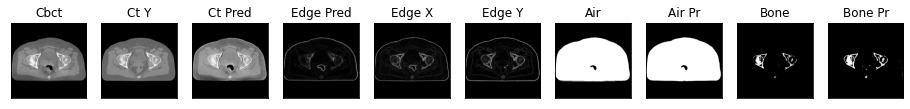

177it [01:09,  2.66it/s]

ssim score = 0.820965051651001
psnr score = 22.89250373840332
snr score = 13.6505126953125
mae error = 0.03321952372789383
air dice score = 0.9948068090091543
bone dice score = 0.874308543333216
contour dice score = 0.3886342942714691


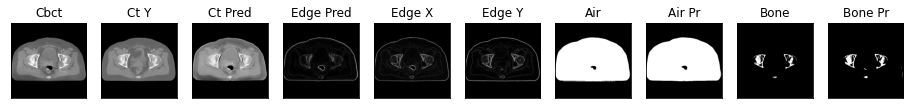

178it [01:09,  2.67it/s]

ssim score = 0.8246014714241028
psnr score = 23.196006774902344
snr score = 13.946012496948242
mae error = 0.033219218254089355
air dice score = 0.9948638022032554
bone dice score = 0.8884522370028952
contour dice score = 0.3456328809261322


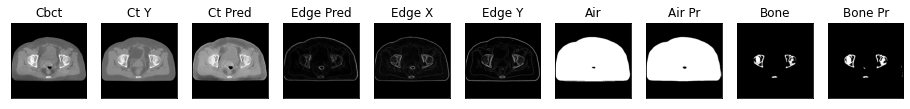

179it [01:10,  2.30it/s]

ssim score = 0.8222352266311646
psnr score = 23.669557571411133
snr score = 14.453794479370117
mae error = 0.032034460455179214
air dice score = 0.9951249666334205
bone dice score = 0.9091178211973192
contour dice score = 0.28625234961509705


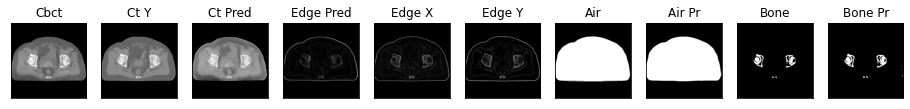

180it [01:10,  2.41it/s]

ssim score = 0.8193551301956177
psnr score = 23.388980865478516
snr score = 14.224710464477539
mae error = 0.03271688148379326
air dice score = 0.99534066179343
bone dice score = 0.92797319933108
contour dice score = 0.25589224696159363


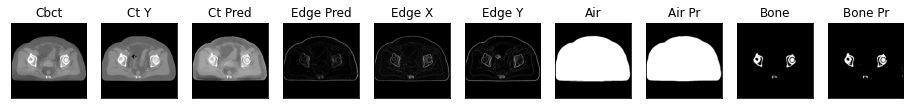

181it [01:11,  2.48it/s]

ssim score = 0.8066675662994385
psnr score = 22.8092041015625
snr score = 13.682490348815918
mae error = 0.03435934707522392
air dice score = 0.9956011121716427
bone dice score = 0.9254850807121232
contour dice score = 0.27285921573638916


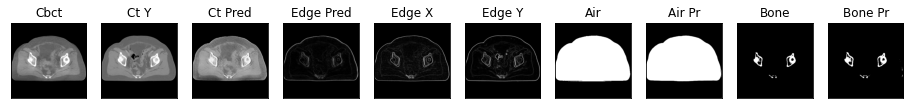

182it [01:11,  2.54it/s]

ssim score = 0.7910283803939819
psnr score = 21.390344619750977
snr score = 12.191194534301758
mae error = 0.039214976131916046
air dice score = 0.9952226020345158
bone dice score = 0.8801907411110632
contour dice score = 0.2672540247440338


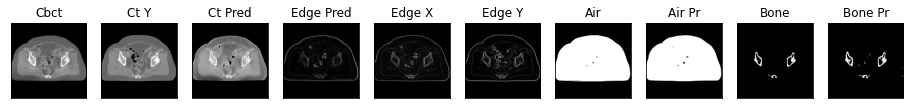

183it [01:11,  2.58it/s]

ssim score = 0.7799217104911804
psnr score = 21.04086685180664
snr score = 11.823722839355469
mae error = 0.04124413803219795
air dice score = 0.9952758700727766
bone dice score = 0.889873162877192
contour dice score = 0.27808016538619995


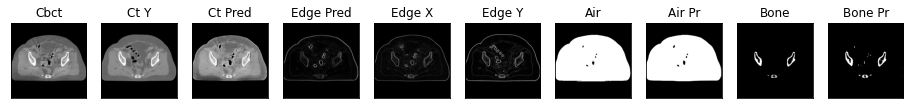

184it [01:12,  2.62it/s]

ssim score = 0.7730394005775452
psnr score = 21.459522247314453
snr score = 12.307291984558105
mae error = 0.04075431823730469
air dice score = 0.9950472638328671
bone dice score = 0.9091983454814024
contour dice score = 0.2571711242198944


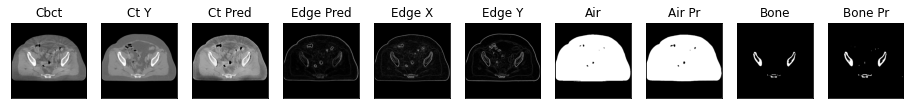

185it [01:12,  2.63it/s]

ssim score = 0.7745501399040222
psnr score = 21.81307029724121
snr score = 12.715935707092285
mae error = 0.03925658017396927
air dice score = 0.9942933690555966
bone dice score = 0.9176551487034957
contour dice score = 0.24227318167686462


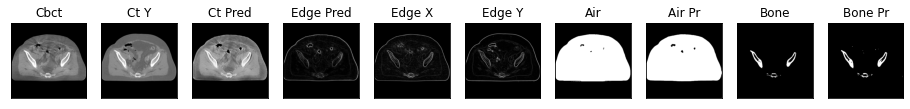

186it [01:13,  2.65it/s]

ssim score = 0.7678656578063965
psnr score = 21.420251846313477
snr score = 12.387547492980957
mae error = 0.0397692546248436
air dice score = 0.9941754013533275
bone dice score = 0.9199124726488707
contour dice score = 0.2222222238779068


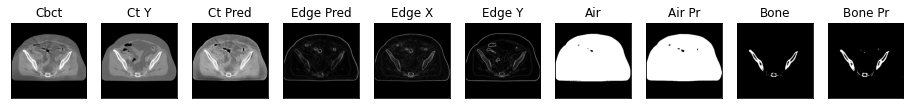

187it [01:13,  2.66it/s]

ssim score = 0.7651003003120422
psnr score = 21.356475830078125
snr score = 12.396629333496094
mae error = 0.039583854377269745
air dice score = 0.9940964703869253
bone dice score = 0.9041461138527643
contour dice score = 0.21224087476730347


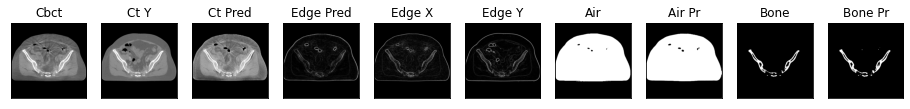

188it [01:13,  2.67it/s]

ssim score = 0.7643887400627136
psnr score = 21.336669921875
snr score = 12.372532844543457
mae error = 0.039571959525346756
air dice score = 0.9942304428983577
bone dice score = 0.8713473489373086
contour dice score = 0.22689487040042877


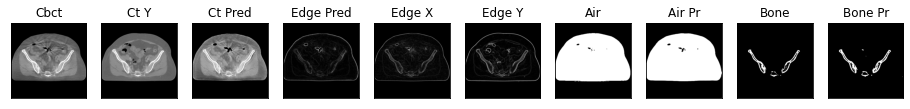

189it [01:14,  2.29it/s]

ssim score = 0.767579972743988
psnr score = 21.384937286376953
snr score = 12.398625373840332
mae error = 0.03908686712384224
air dice score = 0.9949060726337189
bone dice score = 0.8784202374822093
contour dice score = 0.20388349890708923


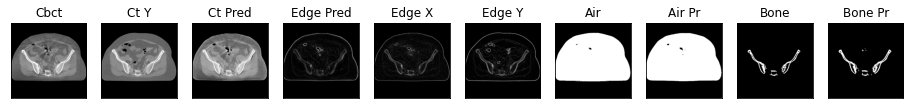

190it [01:14,  2.40it/s]

ssim score = 0.7733821272850037
psnr score = 21.97576332092285
snr score = 13.001084327697754
mae error = 0.037375226616859436
air dice score = 0.9948676546911975
bone dice score = 0.8697046639065922
contour dice score = 0.2035697102546692


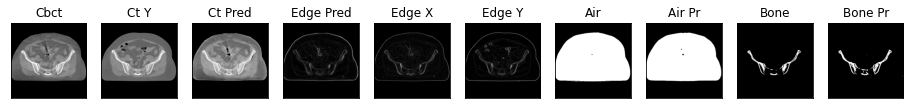

191it [01:15,  2.54it/s]


In [41]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [42]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

<All keys matched successfully>

In [43]:
edge_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
edge_discriminator.load_state_dict(checkpoint["edge_discriminator"])

<All keys matched successfully>

In [44]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
#             score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:07, 25.56it/s]


(0.8057562858646453,
 22.218277436900514,
 13.222549398532088,
 0.03361414058904373,
 0.995024108482643,
 0.8958045334662647,
 0.3758848030217655,
 0.5392670157068062,
 0.56282722513089)

In [45]:
# import torchvision.models as models
# models.vgg16(pretrained=True)